# Введение

## Введение

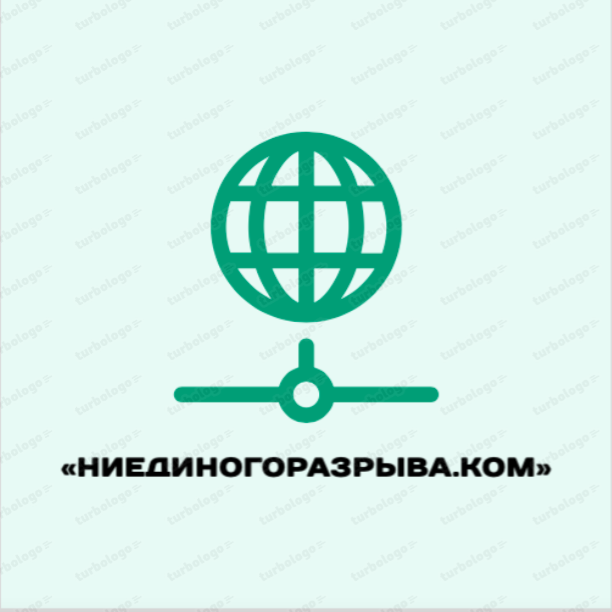

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.



Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## ***Цель проекта***

Подготовка обученноей модели машинного обучения, предсказывающей вероятность оттока клиентов Оператора связи «Ниединогоразрыва.ком»

# Импорт билиотек проекта и загрузка исходных файлов


In [1]:
#!pip install phik > /dev/null

In [2]:
#!pip install imblearn > /dev/null

In [3]:
#импорт стандартных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

#импорт библиотек, связанных с резделением выборок и пайплайнами
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

#импорт библиотек выбора моделей
from sklearn.model_selection import GridSearchCV, StratifiedKFold,cross_val_score,cross_val_predict

#импорт библиотек, связанных с преобразованиями данных
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

#импорт библиотек с используемыми моделями
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from xgboost import XGBClassifier,plot_importance
from catboost import CatBoostClassifier

#импорт библиотек с метриками качества
from sklearn.metrics import accuracy_score,confusion_matrix, recall_score, precision_score
from sklearn.metrics import roc_auc_score,roc_curve, auc
import phik


import warnings
warnings.filterwarnings('ignore')

In [4]:
try:
    contract = pd.read_csv('datasets/contract_new.csv')
    personal = pd.read_csv('datasets/personal_new.csv')
    internet = pd.read_csv('datasets/internet_new.csv')
    phone = pd.read_csv('datasets/phone_new.csv')
except:
    contract = pd.read_csv('/datasets/contract_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')

# Предобработка данных

Просмотрим все датасеты

In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [7]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [8]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [11]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [12]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Все 4е датасета имеют поле с идентификатором пользователя, однако прежче чем объединять файлы в один - стоит проверить имеем ли мы дело со сквозной идентификацией

## Проверка на сквозную идентификцию ползователей

Проверим пересечения Customer_id

In [13]:
len(set(contract['customerID']) & set(
    personal['customerID'])) == len(contract['customerID'])

True

In [14]:
users = pd.DataFrame(contract['customerID'])

Пользователи в contract и personal абсолютно пересакаются. 

In [15]:
len(set(contract['customerID']) & set(
    internet['customerID'])) == len(internet['customerID'])

True

In [16]:
len(set(contract['customerID']) & set(
    phone['customerID'])) == len(phone['customerID'])

True

В internet и phone не появлется новых customerID

In [17]:
print(f'''Пользователей, которые используют обе услуги от Оператора связи «Ниединогоразрыва.ком»:\
{len(set(internet['customerID'])&set(phone['customerID']))}''')

Пользователей, которые используют обе услуги от Оператора связи «Ниединогоразрыва.ком»:4835


## Объединение Данных 

Так как идентификация пользователей сквозная мы можем объединить все 4е файла с данными в один, объединяя по id пользователя.

In [18]:
df = contract.merge(personal, how='left', on='customerID')
df = df.merge(internet, how='left', on='customerID')
df = df.merge(phone, how='left', on='customerID')

In [19]:
del personal, internet, phone

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


## Переименование столбцов

Для удобства работы с данными приведем названия полей к snake_case

In [21]:
df.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
              'payment_method', 'monthly_charges', 'total_charges', 'gender',
              'senior_citizen', 'partner', 'dependents', 'internet_service',
              'online_security', 'online_backup', 'device_protection', 'tech_support',
              'streaming_tv', 'streaming_movies', 'multiple_lines']

## Изменение типов столбцов + добавление новых

Столбцы begin_date, end_date содержат дату, приведем их к нужному формату + добавим новые столбцы:
1/churned - целевая переменная - отказался ли клиент от услуг или нет.
2/время, которое клиент пользуется(или пользовался, если уже не является клиентом) услугами компании


In [22]:
df['begin_date']

0       2020-01-01
1       2017-04-01
2       2019-10-01
3       2016-05-01
4       2019-09-01
           ...    
7038    2018-02-01
7039    2014-02-01
7040    2019-03-01
7041    2019-07-01
7042    2014-08-01
Name: begin_date, Length: 7043, dtype: object

In [23]:
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')


In [24]:
df['churned'] = df['end_date'].apply(lambda x: x != "No")

In [25]:
# Для текущих пользователей за дату окончания примем дату актуальности данных
df.loc[df['end_date'] == 'No', 'end_date'] = '2020-02-01'

In [26]:
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')

In [27]:
df['lifetime'] = (df['end_date']-df['begin_date']).dt.days

Столбец 'total_charges' имеет тип object, хотя по содержанию он должен быть или int или float.
Исследуем данные в нем.

In [28]:
sum(df['total_charges'] == " ")

11

In [29]:
df.query('total_charges==" "')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned,lifetime
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,...,DSL,Yes,No,Yes,Yes,Yes,No,NaN,False,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,False,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,Female,0,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,False,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,False,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,Female,0,...,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,False,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,False,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,False,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,Female,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,False,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,False,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,Female,0,...,DSL,No,Yes,Yes,Yes,Yes,No,Yes,False,0


В данных имеются данные пользователей, которые только в этом месяце стали клиентами компании, поэтому для них нет данных о total_charges, так как они еще не успели произвести ни одн оплату. Заменим для них значение в этом поле на 0, что точно не исказит данные.

In [30]:
df.loc[df['total_charges'] == " ", 'total_charges'] = df.loc[df['total_charges'] == " ", 'monthly_charges']

In [31]:
df['total_charges'] = df['total_charges'].astype('float')

## Проверка на явные и неявные дубликаты

проверим категориальный переменные на предмет неявных дубликатов. Для этого выведем уникальные значения.


In [32]:
categorical = ['type', 'paperless_billing',
               'payment_method', 'gender',
               'senior_citizen', 'partner', 'dependents', 'internet_service',
               'online_security', 'online_backup', 'device_protection',
               'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

In [33]:
for col in categorical:
    print(f'''Уникальные значения в столбце {col}:''')
    print(df[col].unique())
    print()

Уникальные значения в столбце type:
['Month-to-month' 'One year' 'Two year']

Уникальные значения в столбце paperless_billing:
['Yes' 'No']

Уникальные значения в столбце payment_method:
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

Уникальные значения в столбце gender:
['Female' 'Male']

Уникальные значения в столбце senior_citizen:
[0 1]

Уникальные значения в столбце partner:
['Yes' 'No']

Уникальные значения в столбце dependents:
['No' 'Yes']

Уникальные значения в столбце internet_service:
['DSL' 'Fiber optic' nan]

Уникальные значения в столбце online_security:
['No' 'Yes' nan]

Уникальные значения в столбце online_backup:
['Yes' 'No' nan]

Уникальные значения в столбце device_protection:
['No' 'Yes' nan]

Уникальные значения в столбце tech_support:
['No' 'Yes' nan]

Уникальные значения в столбце streaming_tv:
['No' 'Yes' nan]

Уникальные значения в столбце streaming_movies:
['No' 'Yes' nan]

Уникальные значения в столбце multiple_lin

Неявных дубликатов не выявлено, но были выявлены пропуски в данных: при соединении данных у нас появились пользователи, которые не пользуются рядом услуг и поэтому данных о них не было в одной из баз данных (phone/internet). Соотвественно эти пропуски мы можем заменить на "No", так как они не пользуются данными услугами и мы не исказим данные.

In [34]:
df['multiple_lines'] = df['multiple_lines'].fillna("no_stationary_phone")
df['internet_service'] = df['internet_service'].fillna("no_internet_service")

In [35]:
for col in categorical:
    df[col] = df[col].fillna("No")

Проверим остальные столбцы на наличие пропусков.

In [36]:
df.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
churned              0
lifetime             0
dtype: int64

Пропуски отсутствуют

Проверим данные на явные дубликаты. 
Так как customer_id - уникальный, чтобы исключить ошибку - приведем его к нижнему регистру и после проверим данное поле на дубликаты.

In [37]:
df['customer_id_low'] = df['customer_id'].str.lower()

In [38]:
df['customer_id_low'].duplicated().sum()

0

Дублирующиеся идентификационные номера отсуствуют

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

## ***Выводы***

В ходе проведения первичной предобработки данных мною было проведена проверка на скводную идентификацию пользователей в имеющихся данных из разных источников с последющим объединением их. Так же я произвела переминование столбцов/переменных в стиле snake_makе. В данных не было выявлено ни явних ни неявных дубликатов. Также мною были добавленные новые столбцы с данными: "время жизни" клиента и факт его отказа от услуг компании. Данные в dataframe приведены к необходимым форматам.

# Исследовательский анализ данных - EDA

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

В нашем рапоряжении данные 7043 клиентов оператора связи «Ниединогоразрыва.ком». 

## Дата прихода/оттока клиента, lifetime клиента

### *Привлечение клиентов по годам*

In [41]:
df['begin_year'] = pd.DatetimeIndex(df['begin_date']).year

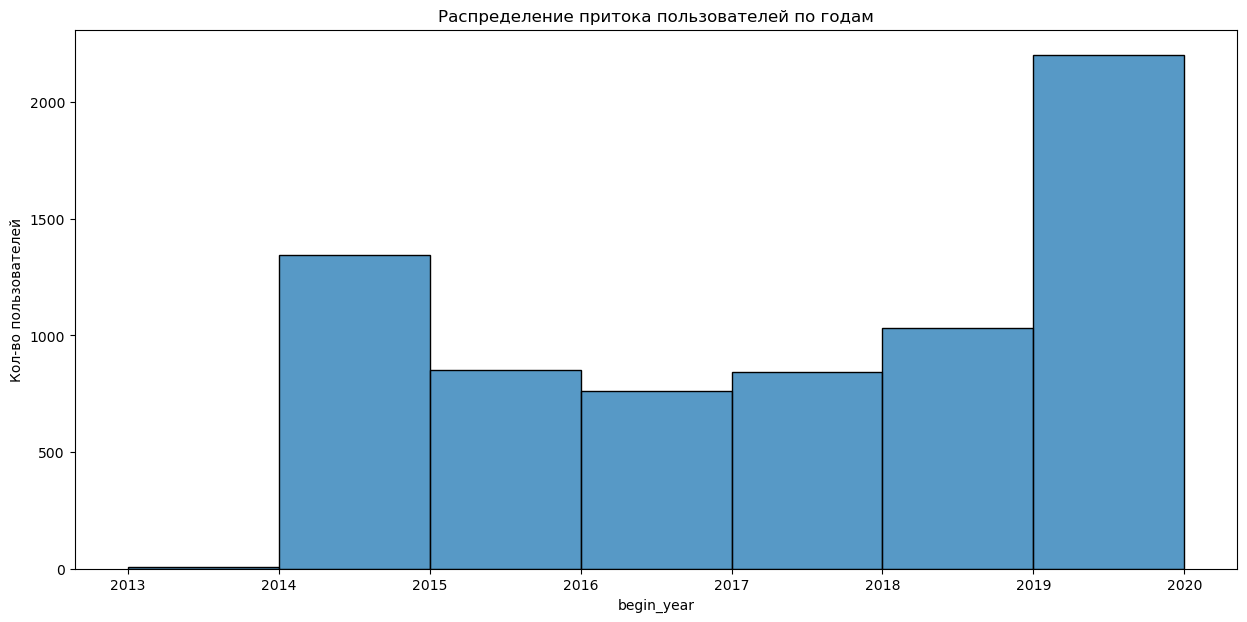

In [42]:
plt.figure(figsize=(15, 7))

sns.histplot(data=df['begin_year'],bins = range(2013, 2021))

plt.title('Распределение притока пользователей по годам')
plt.ylabel('Кол-во пользователей')
plt.show()

Судя по данным, компания в 2019 году привлекла почти вдвое больше клиентов, чем в каждом из 4 предыдущих.Даные за 2020 год пока не полные.

### *Отток клиентов по годам*

In [43]:
df['end_year'] = pd.DatetimeIndex(df['end_date']).year

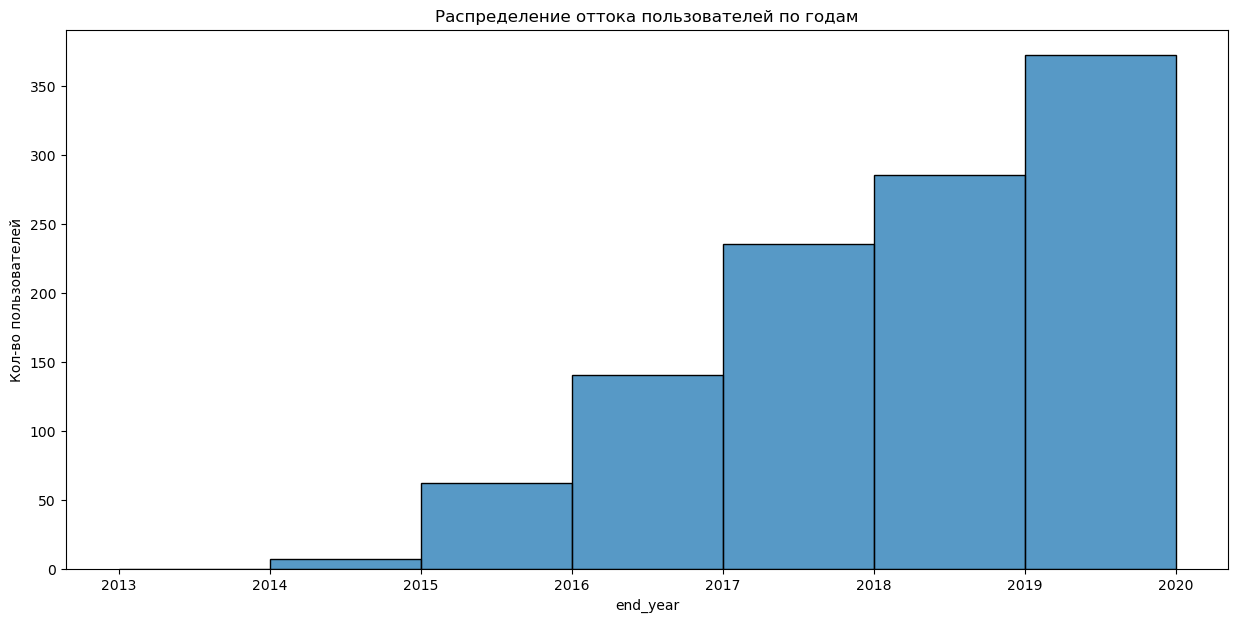

In [44]:
plt.figure(figsize=(15, 7))

sns.histplot(data=df.loc[df['churned'] == True, 'end_year'],bins = range(2013, 2021))
plt.title('Распределение оттока пользователей по годам')

plt.ylabel('Кол-во пользователей')
plt.show()

За последние годы дейятельности компании можно отметить рост кол-во оттекающих клиентов от года к году, однако для более точной картины необходимо оценить эту тенденцию в относительных величинах (% оттока от всех активных клиентов)

### *Активные клиеты по годам + % оттока*

In [45]:
years = range(2014, 2021)
active_users = []
for y in years:
    count = len(df.query('begin_year<=@y and end_year>=@y'))
    active_users.append(count)

In [46]:
churned = pd.DataFrame(df.groupby('end_year')['customer_id'].count())
# Изменим число оттекших клиентов для 2020 года - добавив фильтр по полю churned
churned.loc[2020] = len(df.query('end_year==2020 and churned ==True'))

churned['active'] = active_users
churned.columns = ['churned', 'active']
churned['churn_rate'] = round(churned['churned']/churned['active']*100, 2)
churned.index.names = ['year']

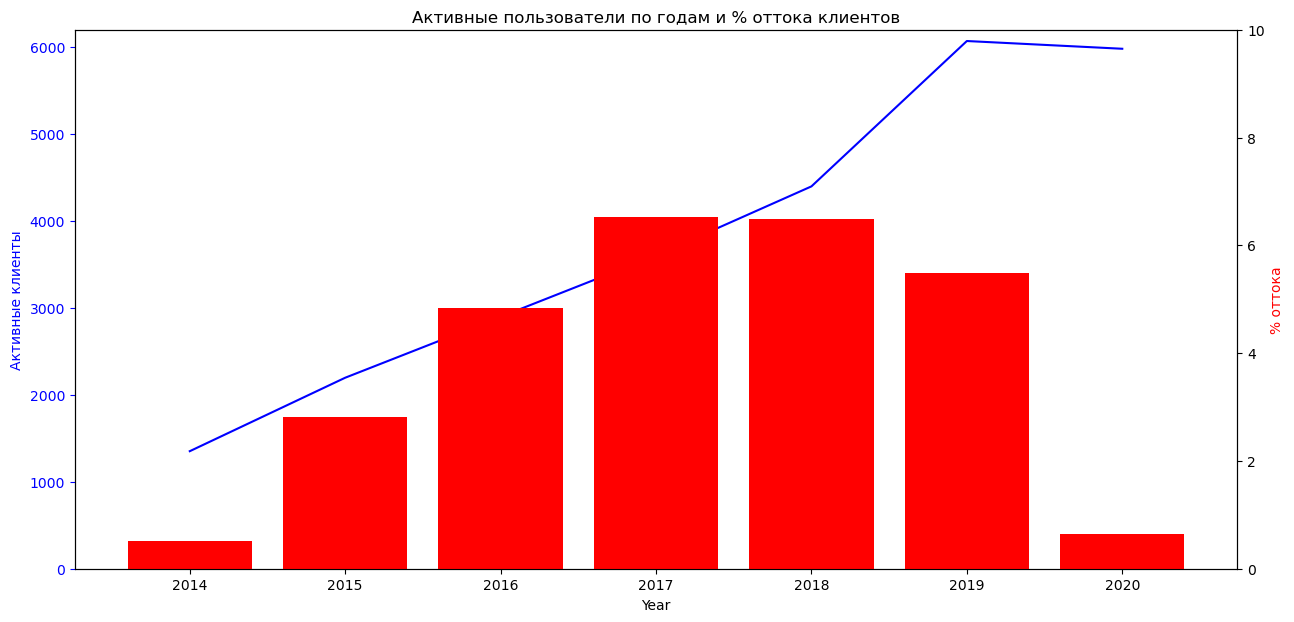

In [47]:
fig, ax1 = plt.subplots(figsize=(15, 7))

ax1.plot(churned['active'], 'b-')
ax1.set_xlabel('Year')
ax1.set_ylabel('Активные клиенты', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()

ax2.bar(x=churned.index, height=churned['churn_rate'], color='r')
ax2.set_ylabel('% оттока', color='r')
ax1.set_ylim([0, 6200])
ax2.set_ylim([0, 10])
plt.title('Активные пользователи по годам и % оттока клиентов')

plt.show()

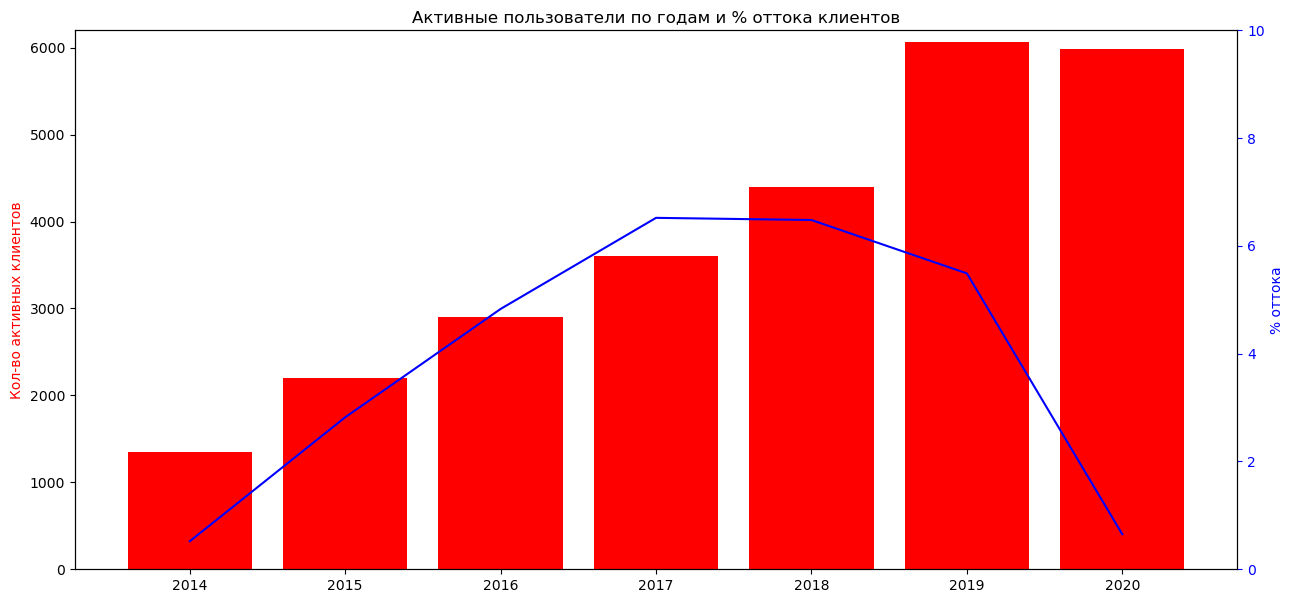

In [51]:
fig, ax1 = plt.subplots(figsize=(15, 7))

ax1.bar(x=churned.index, height=churned['active'], color='r')
ax1.set_ylabel('Кол-во активных клиентов', color='r')


ax2 = ax1.twinx()




ax2.plot(churned['churn_rate'], 'b-')
ax2.set_xlabel('Year')
ax2.set_ylabel('% оттока', color='b')
ax2.tick_params('y', colors='b')

ax1.set_ylim([0, 6200])
ax2.set_ylim([0, 10])
plt.title('Активные пользователи по годам и % оттока клиентов')
plt.show()

In [50]:
churned

,churned,active,churn_rate
year,,,
2014,7,1352,0.52
2015,62,2197,2.82
2016,140,2898,4.83
2017,235,3603,6.52
2018,285,4398,6.48
2019,333,6070,5.49
2020,39,5981,0.65


При стабильно увеличивающемся кол-ве активных клиентов компании мы можем отметить заметный рост % оттока клиентов в 2017 году и сохранением этой тенденции в следующем году. В 2019 году было заметное снижение % оттока клиентов относительно всех активных абонентов. 

### *Lifetime клиентов*

In [48]:
table = pd.pivot_table(df, values='lifetime', index='churned', aggfunc=[np.mean,
                                                                        lambda x: np.percentile(
                                                                            x, 25),
                                                                        lambda x: np.percentile(
                                                                            x, 50),
                                                                        lambda x: np.percentile(x, 75)])
table.columns = ['mean', '25-perc', '50-perc', '75-perc']
print('Средний, 25-50-75 перцентили lifetime отточных vs лояльных клиентов')
print(table)

Средний, 25-50-75 перцентили lifetime отточных vs лояльных клиентов
               mean  25-perc  50-perc  75-perc
churned                                       
False    893.681084      245      702     1523
True     924.863760      577      915     1249


В 25% случаях, клиенты решающие отказаться от услуг компании делают это в течение 1го года, а половина оттекающих клиентов делают это спустя не более 2.5 лет.

Среди активных клиентов (на момент составления отчета) более 75% являются клиентами не  менее полутора лет, а половина клиентов сотрудничают с компанией уже почти два года.

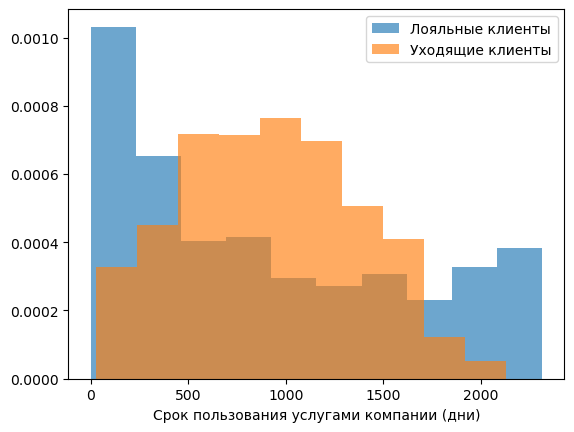

In [219]:
plt.hist(df.loc[df['churned'] == False,'lifetime'], density=True, alpha=0.65, label='Лояльные клиенты')
plt.hist(df.loc[df['churned'] == True,'lifetime'], density = True, alpha=0.65, label='Уходящие клиенты')
plt.xlabel('Срок пользования услугами компании (дни)')

plt.legend(loc='upper right')
plt.show()

## Тип договора, и платежная информация о клиентах

### *Тип договора*

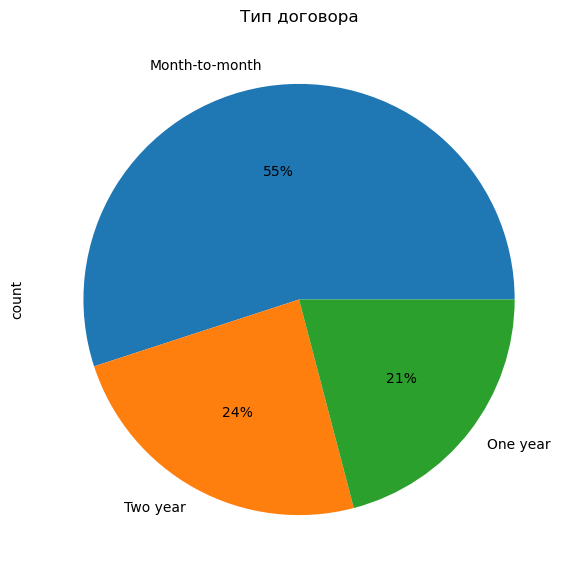

In [50]:
df['type'].value_counts().plot(kind='pie', autopct='%1.f%%', figsize=(15, 7))
plt.title('Тип договора')
plt.show()

Более половины всех клиентов предпочитают платить за выбранные услуги помесячно продлевая договор. Оставшиеся 45% почти в равных долях выбирают заключать договор на один год или на два. 

Посмотрим, меняются ли предпочтения клиентов в подгруппах в зависимости от факта оттока.

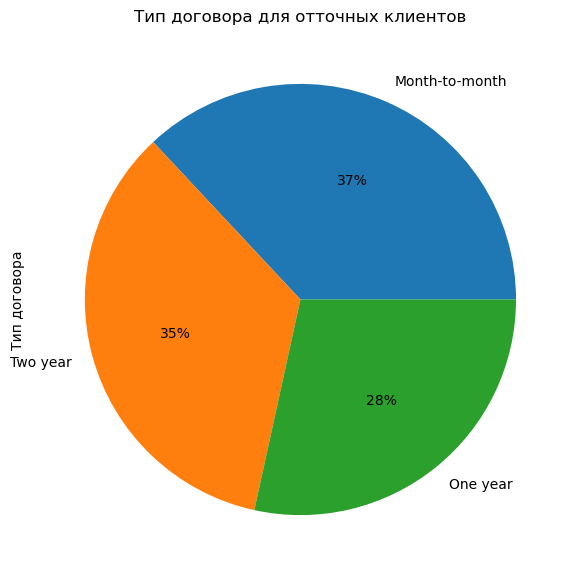

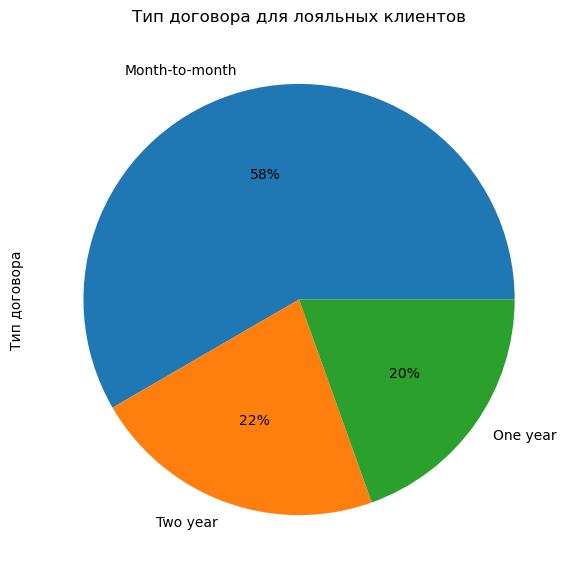

In [51]:
for i in [True, False]:
    df.loc[df['churned'] == i, 'type'].value_counts().plot(
        kind='pie', autopct='%1.f%%', figsize=(15, 7))
    if i == True:
        title = 'Тип договора для отточных клиентов'
    else:
        title = 'Тип договора для лояльных клиентов'
    plt.ylabel('Тип договора')
    plt.title(title)
    plt.show()
    print()

Распределение предпочтений по типу договора для лояльных клиентов практически аналогично средневыборочному, однако для пользователей,которые предпочти отказаться от услуг нет превалирующего над другими типа договора: доли для каждого почти равны относительно друг друга.

### *Способ выставления счета*

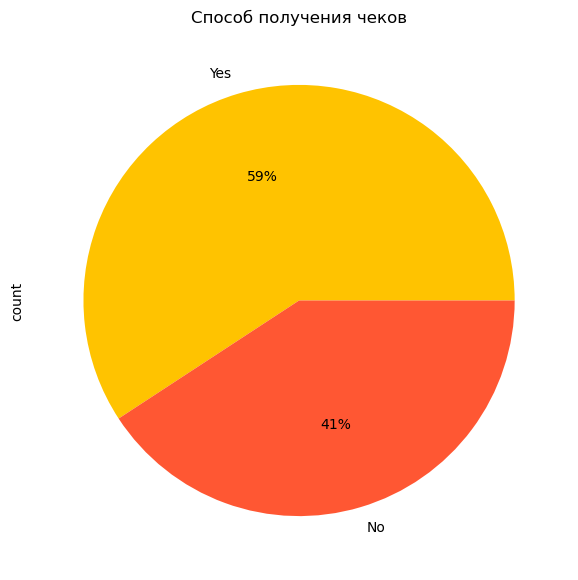

In [52]:
colors = ['#FFC300', '#FF5733']
df['paperless_billing'].value_counts().plot(
    kind='pie', autopct='%1.f%%', figsize=(15, 7), colors=colors)
plt.title('Способ получения чеков')
plt.show()

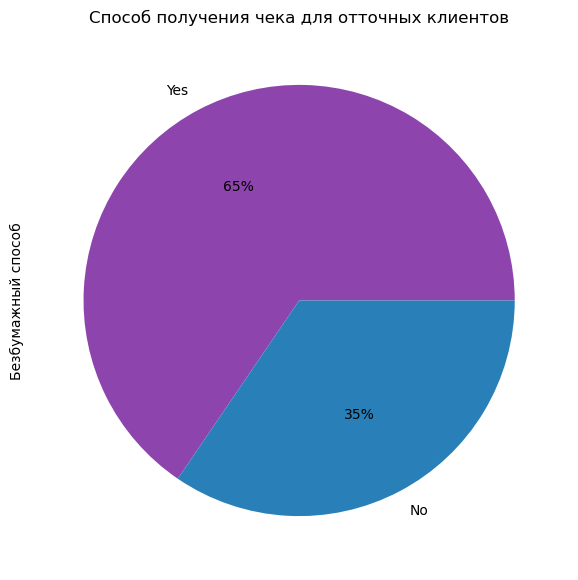

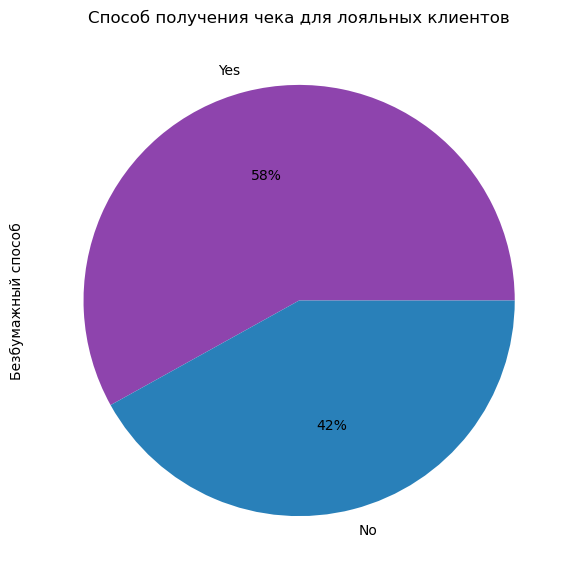

In [53]:
colors = ['#8E44AD', '#2980B9']
for i in [True, False]:
    df.loc[df['churned'] == i, 'paperless_billing'].value_counts().plot(
        kind='pie', autopct='%1.f%%', figsize=(7, 7), colors=colors)
    if i == True:
        title = 'Способ получения чека для отточных клиентов'
    else:
        title = 'Способ получения чека для лояльных клиентов'
    plt.ylabel('Безбумажный способ')
    plt.title(title)
    plt.show()
    print()

Как для всех типов клиентов (лояльных и отточных) вместе и по отдельности предпочтения по способу выставления счета практически не отличаются, из чего можно сделать вывод, что данная переменная будет не самой инорфмативной для прогноза вероятности оттока клиента. 

### *Способ оплаты счета*

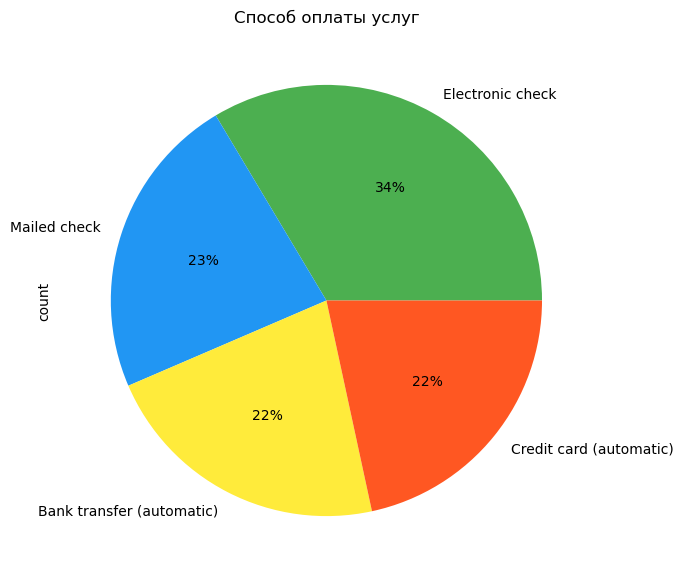

In [54]:
colors = ['#4CAF50', '#2196F3','#FFEB3B', '#FF5722']
df['payment_method'].value_counts().plot(
    kind='pie', autopct='%1.f%%', figsize=(15, 7), colors=colors)
plt.title('Способ оплаты услуг')
plt.show()

44% Клиентов предпочитают автоматизировать оплату услуг компании. В целом все 4е способа оплаты имебт почти равную популярность среди клиентов (на 10% от всех остальных отрывается Электронный чек)

Проанализируем: меняются ли предпочтения в зависимости от степени лояльности компании.

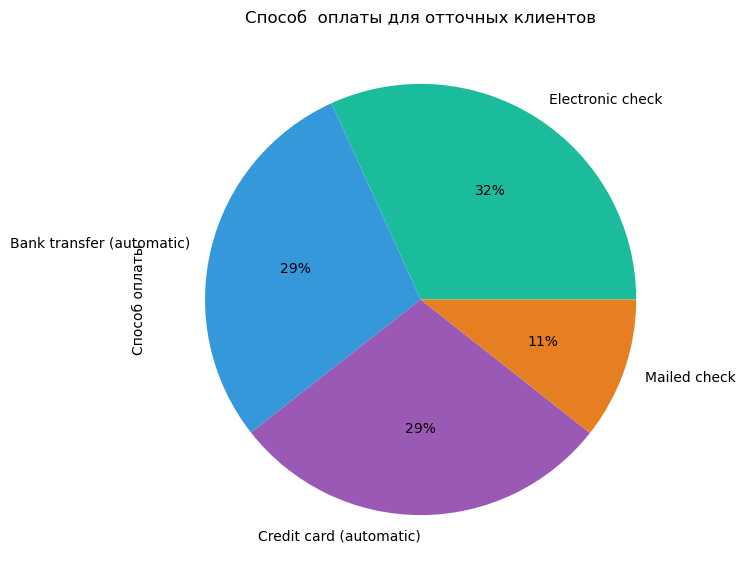

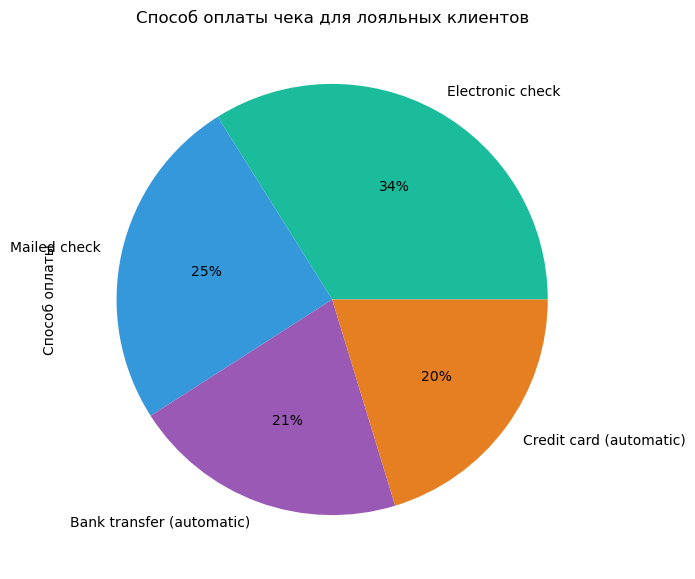

In [55]:
colors = ['#1ABC9C', '#3498DB', '#9B59B6', '#E67E22']
for i in [True, False]:
    df.loc[df['churned'] == i, 'payment_method'].value_counts().plot(
        kind='pie', autopct='%1.f%%', figsize=(7, 7), colors=colors)
    if i == True:
        title = 'Способ  оплаты для отточных клиентов'
    else:
        title = 'Способ оплаты чека для лояльных клиентов'
    plt.ylabel('Способ оплаты')
    plt.title(title)
    plt.show()
    print()

Лояльные клиенты в 40% случаев предпочитают автоматизировать оплату своих счетов.
А клиенты, которые в итоге оттекли - в 58% случаев предпочитали автоматизацию,  только в 10% - оплачивали по почте.

### *Ежемесячный платеж*

In [56]:
df['monthly_charges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

Ежемесячная плата для всех клиентов варьируется от 18у.е. дло 118.
25% клиентов ещемесячно платят не менее 23у.е.


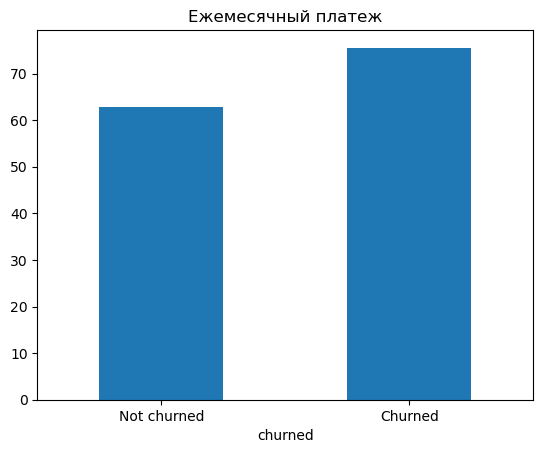

In [57]:
bar = df.groupby('churned')['monthly_charges'].mean().plot(kind='bar')
bar.set_xticklabels(['Not churned', 'Churned'], rotation=0)
plt.title('Ежемесячный платеж')
plt.show()
del bar

Средние ежемесячные платежы различаются в подгруппах. Проверим статистичскую значимость этих различий:
Проверим одностороннюю гипотезу:

H0 = Средний ежемесячный платеж у лояльных клиентов и отточных одинаковый
H1 = Средний ежемесячный платеж у лояльных клиентов ниже, чем у отточных

In [58]:
ALPHA = 0.05
churned = df.loc[df['churned']==True,'monthly_charges'] 
loyal = df.loc[df['churned']==False,'monthly_charges']

results = st.ttest_ind(churned, loyal, equal_var = False)

if results.pvalue/2 < ALPHA and churned.mean()>loyal.mean():
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу в пользу альтернативной


При уровне статистической значимости, приянтой на уровне 95% мы отвергает нулевую гипотезу в пользу альтернативной: при высокой ежемесячной плате вероятность оттока клианта выше, чем при более низкой.

### *LTV - lifetime-value*

In [59]:
df['total_charges'].describe()

count    7043.000000
mean     2115.377573
std      2112.678861
min        19.050000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: total_charges, dtype: float64

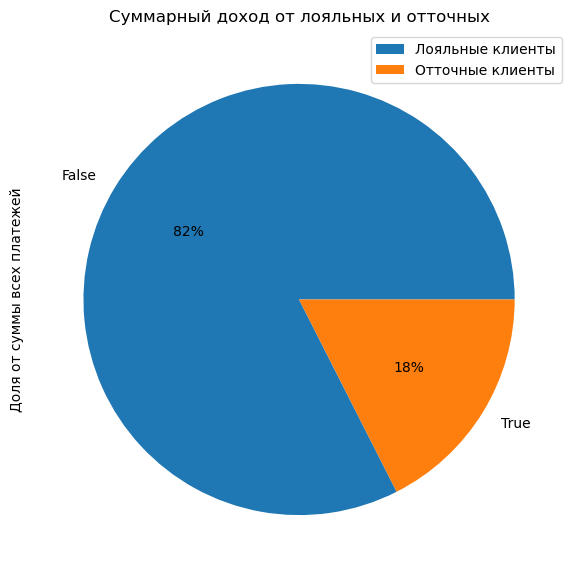

In [60]:
bar = df.groupby('churned')['total_charges'].sum().plot(kind='pie',autopct='%1.f%%', figsize=(7,7))

plt.title('Суммарный доход от лояльных и отточных')
plt.legend(labels=['Лояльные клиенты','Отточные клиенты'])
plt.ylabel('Доля от суммы всех платежей')
plt.show()
del bar

Не смотря на то, что некоторые клиенты отказываются от услуг компании внося более высокий ещемесячный платеж, в общую прибыль они вкладывают всего 18%, тогда как оставшаяся часть приходится на платежи лояльных клиентов компании.

## Соцально-демографическая информация о клиентах

### *Пол клиента*

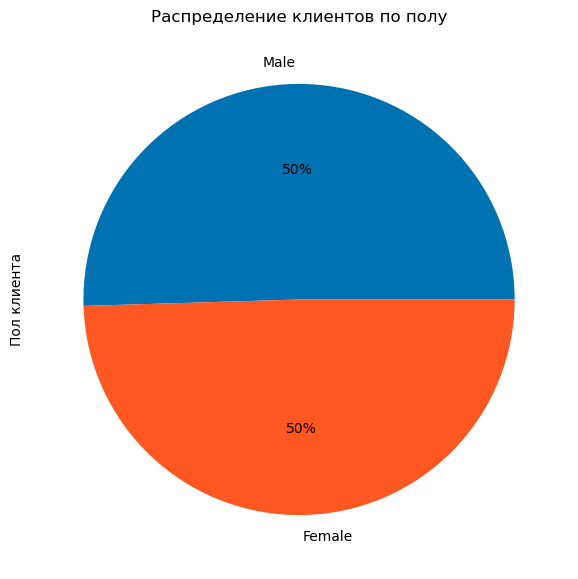

In [61]:
colors = ['#0072B2', '#FF5722']
df['gender'].value_counts().plot(
    kind='pie', autopct='%1.f%%', figsize=(15, 7), colors=colors)
plt.title('Распределение клиентов по полу')
plt.ylabel('Пол клиента')
plt.show()

Среди всех клиентов- мужчин и женщин равное кол-во.

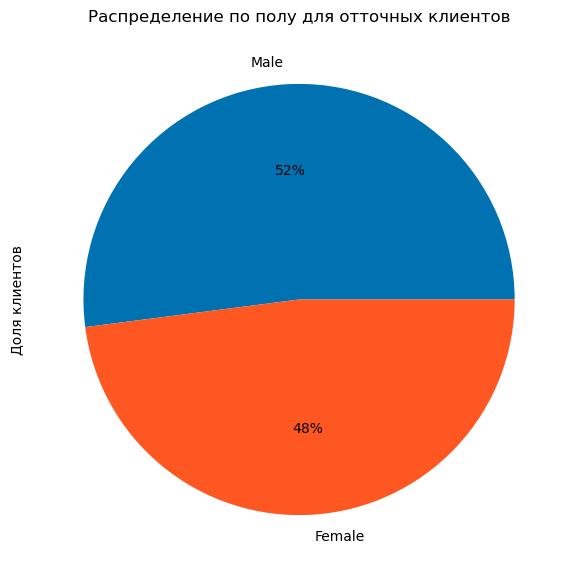

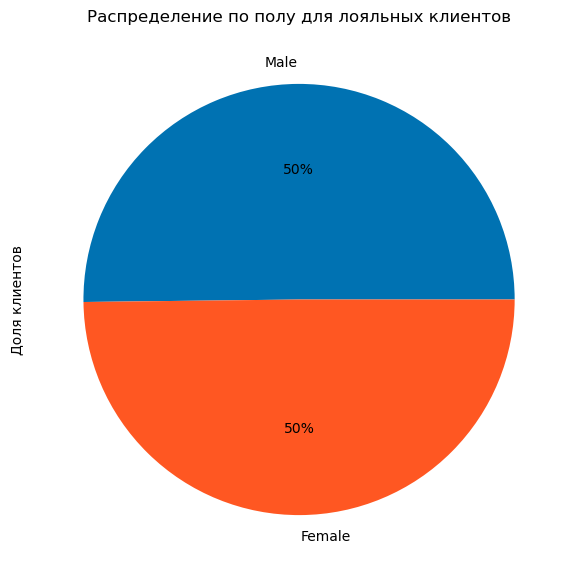

In [62]:
colors = ['#0072B2', '#FF5722']
for i in [True, False]:
    df.loc[df['churned'] == i, 'gender'].value_counts().plot(
        kind='pie', autopct='%1.f%%', figsize=(7, 7), colors=colors)
    if i == True:
        title = 'Распределение по полу для отточных клиентов'
    else:
        title = 'Распределение по полу для лояльных клиентов'
    plt.ylabel('Доля клиентов')
    plt.title(title)
    plt.show()
    print()

Пол клиента не влияет на вероятность его отказа от услуг компании.

### *Клиенты-пенсионеры*

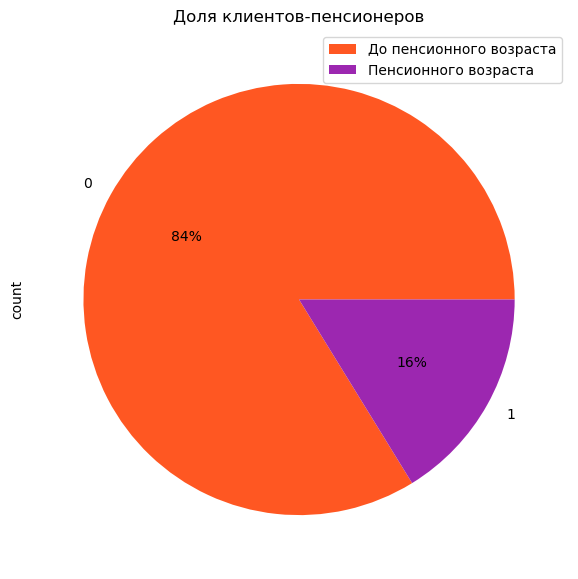

In [63]:
colors = ['#FF5722', '#9C27B0']
df['senior_citizen'].value_counts().plot(
    kind='pie', autopct='%1.f%%', figsize=(15, 7), colors=colors)
plt.title('Доля клиентов-пенсионеров')
plt.legend(labels=['До пенсионного возраста','Пенсионного возраста'])

plt.show()

Всего 16% от всех клиентов уже достигли пенсионного возраста.

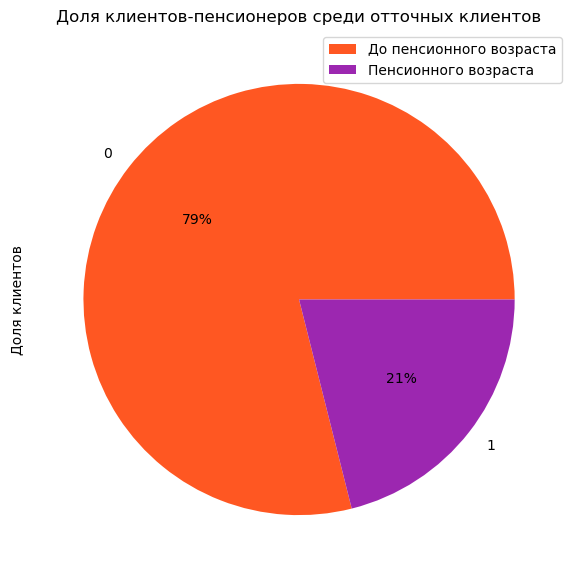

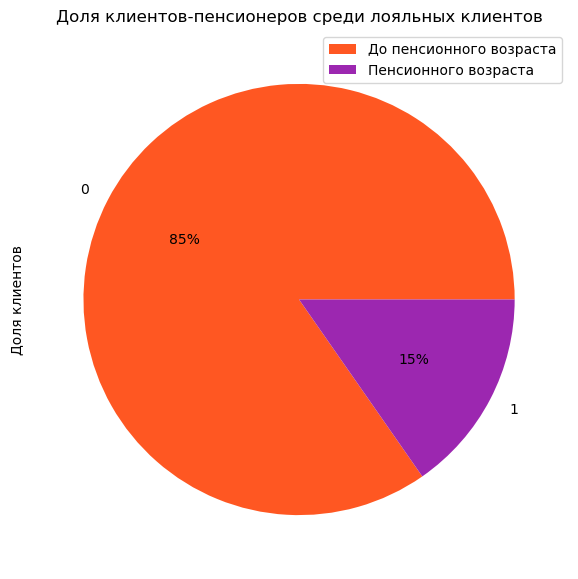

In [64]:
colors = ['#FF5722', '#9C27B0']
for i in [True, False]:
    df.loc[df['churned'] == i, 'senior_citizen'].value_counts().plot(
        kind='pie', autopct='%1.f%%', figsize=(7, 7), colors=colors)
    if i == True:
        title = 'Доля клиентов-пенсионеров среди отточных клиентов'
    else:
        title = 'Доля клиентов-пенсионеров среди лояльных клиентов'
    plt.ylabel('Доля клиентов')
    plt.legend(labels=['До пенсионного возраста','Пенсионного возраста'])
    plt.title(title)
    plt.show()
    print()

Влияние пенсионного возраста на вероятность оттока клиентов незначительно.

### *Наличие партнера у клиента*

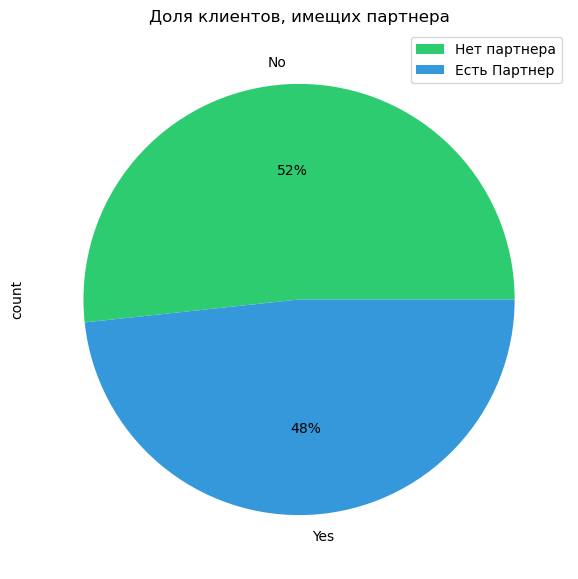

In [65]:
colors = ['#2ECC71', '#3498DB']
df['partner'].value_counts().plot(
    kind='pie', autopct='%1.f%%', figsize=(15, 7), colors=colors)
plt.title('Доля клиентов, имещих партнера')
plt.legend(labels=['Нет партнера','Есть Партнер'])

plt.show()

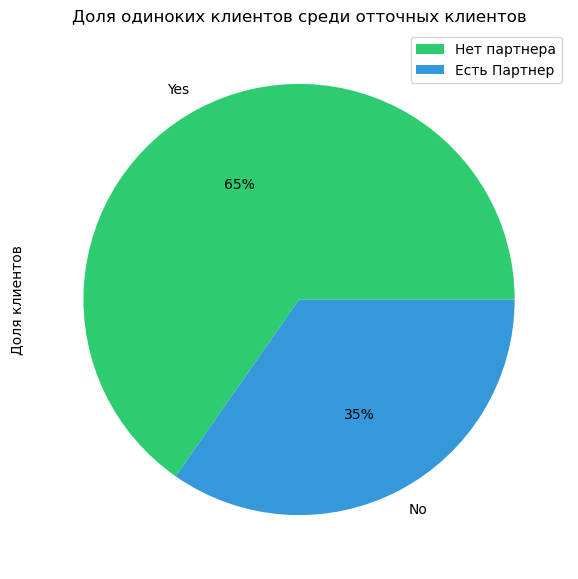

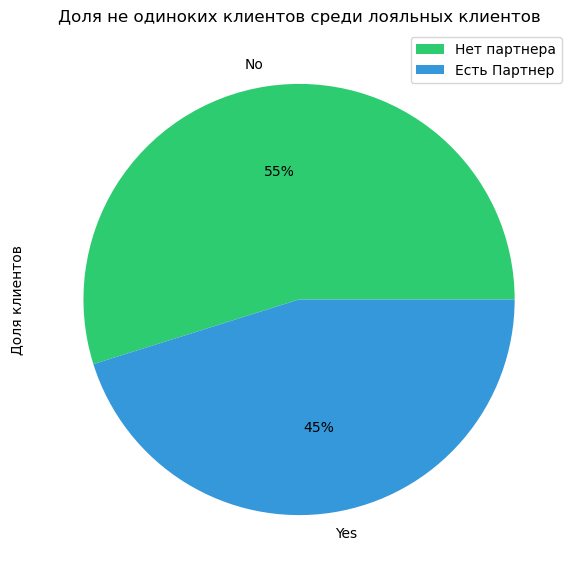

In [66]:
for i in [True, False]:
    df.loc[df['churned'] == i, 'partner'].value_counts().plot(
        kind='pie', autopct='%1.f%%', figsize=(7, 7), colors=colors)
    if i == True:
        title = 'Доля одиноких клиентов среди отточных клиентов'
    else:
        title = 'Доля не одиноких клиентов среди лояльных клиентов'
    plt.ylabel('Доля клиентов')
    plt.legend(labels=['Нет партнера','Есть Партнер'])
    plt.title(title)
    plt.show()
    print()

Среди отточных клиентов доля одиноких клиентов выше, чем у лояльных

### *Наличие лиц на иждивении у клиента*

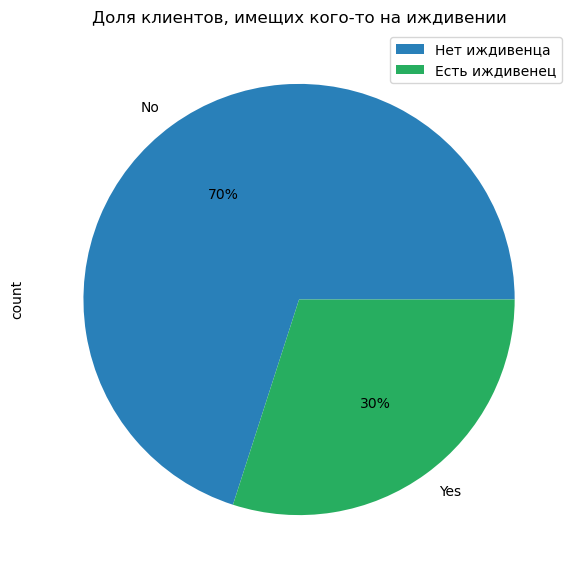

In [67]:
colors = ['#2980B9', '#27AE60']
df['dependents'].value_counts().plot(
    kind='pie', autopct='%1.f%%', figsize=(15, 7), colors=colors)
plt.title('Доля клиентов, имещих кого-то на иждивении')
plt.legend(labels=['Нет иждивенца','Есть иждивенец'])

plt.show()

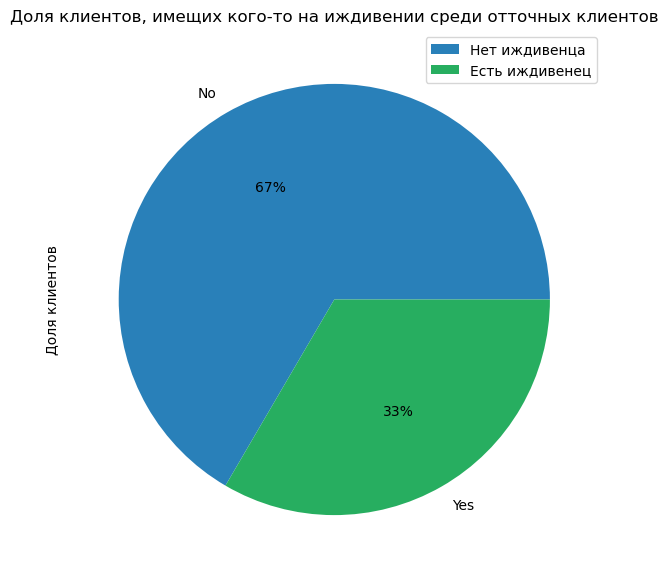

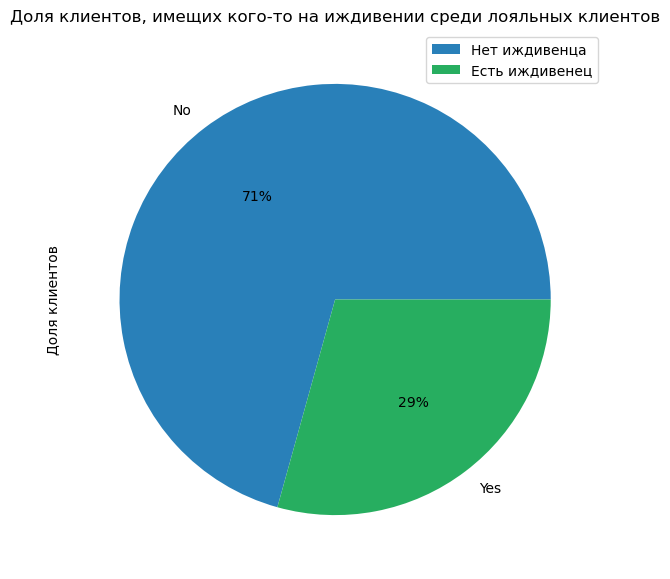

In [68]:
for i in [True, False]:
    df.loc[df['churned'] == i, 'dependents'].value_counts().plot(
        kind='pie', autopct='%1.f%%', figsize=(7, 7), colors=colors)
    if i == True:
        title = 'Доля клиентов, имещих кого-то на иждивении среди отточных клиентов'
    else:
        title = 'Доля клиентов, имещих кого-то на иждивении среди лояльных клиентов'
    plt.ylabel('Доля клиентов')
    plt.legend(labels=['Нет иждивенца','Есть иждивенец'])
    plt.title(title)
    plt.show()
    print()

Наличие у клиента лиц на иждивении не влияет на вероятность его оттока.

## Стационарная телефонная связь и тип подключения к интернету

### *Кол-во каналов стационарной телефонной связи*

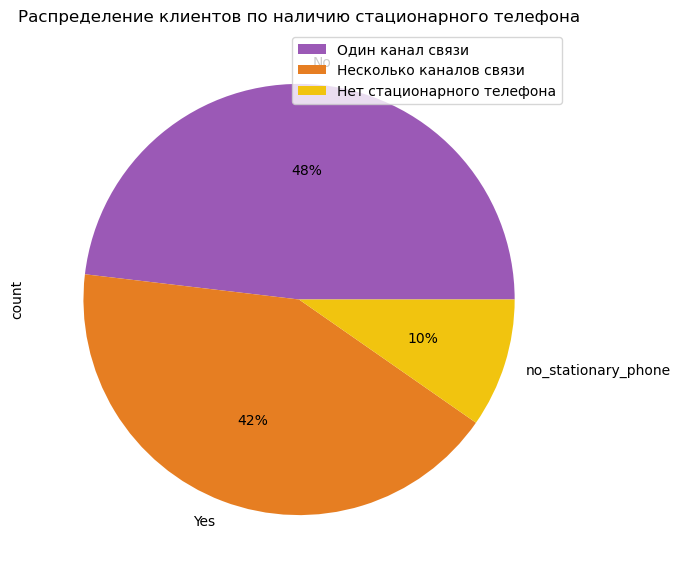

In [69]:

colors = ['#9B59B6', '#E67E22', '#F1C40F']
df['multiple_lines'].value_counts().plot(
    kind='pie', autopct='%1.f%%', figsize=(15, 7), colors=colors)
plt.title('Распределение клиентов по наличию стационарного телефона')
plt.legend(labels=['Один канал связи','Несколько каналов связи','Нет стационарного телефона'])

plt.show()





90% имеют хотя бы один канал связи, предоставленный компанией. 

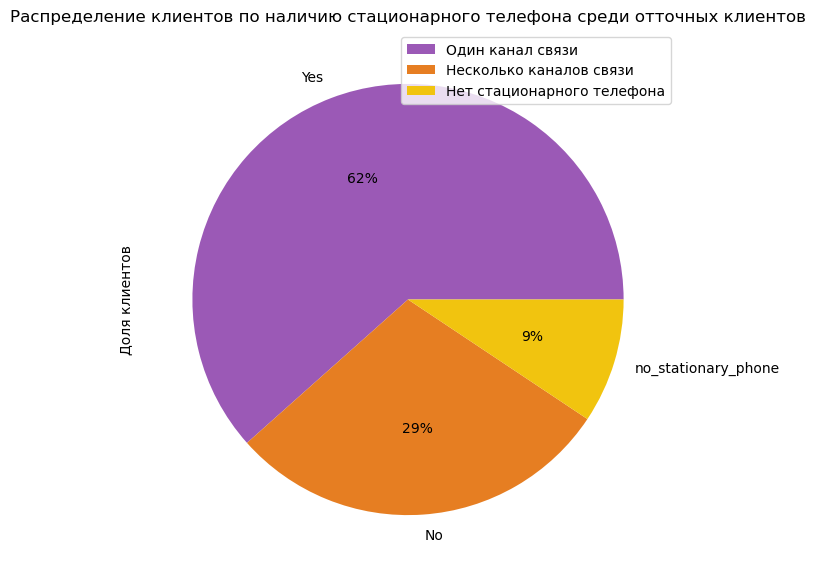

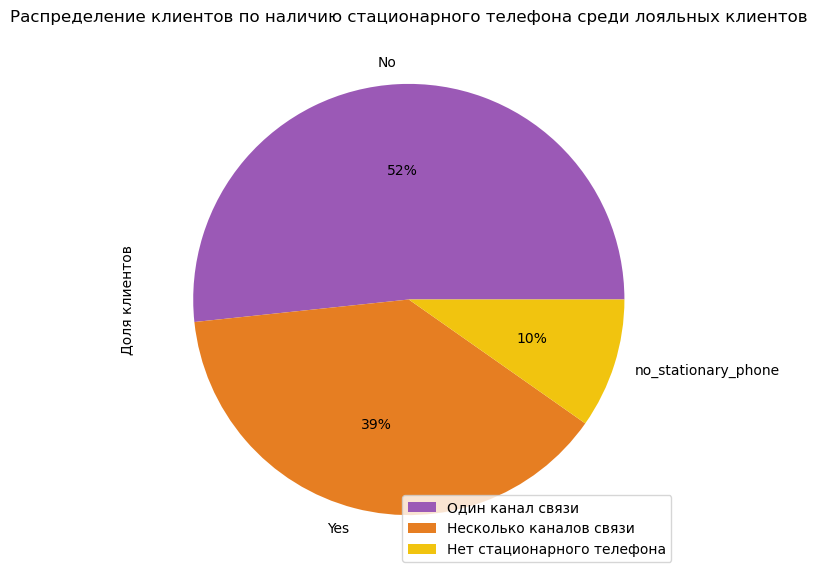

In [70]:
for i in [True, False]:
    df.loc[df['churned'] == i, 'multiple_lines'].value_counts().plot(
        kind='pie', autopct='%1.f%%', figsize=(7, 7), colors=colors)
    if i == True:
        title = 'Распределение клиентов по наличию стационарного телефона среди отточных клиентов'
    else:
        title = 'Распределение клиентов по наличию стационарного телефона среди лояльных клиентов'
    plt.ylabel('Доля клиентов')
    plt.legend(labels=['Один канал связи','Несколько каналов связи','Нет стационарного телефона'])
    plt.title(title)
    plt.show()
    print()

Сравнивая отточных клиентов и лояльных - можно отметить тенденцию, что среди уходяхих чаще встречаются те, кто  используют только один канал связи. 

### *Тип интернет соединения*

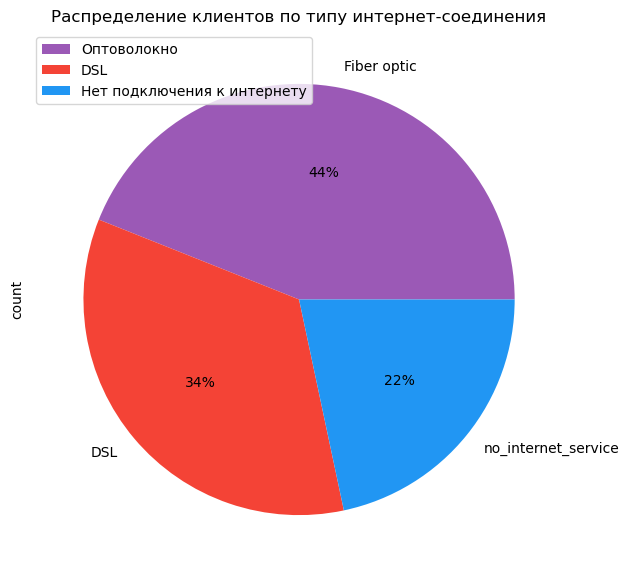

In [71]:
colors = ['#9B59B6', '#F44336', '#2196F3']
df['internet_service'].value_counts().plot(
    kind='pie', autopct='%1.f%%', figsize=(15, 7), colors=colors)
plt.title('Распределение клиентов по типу интернет-соединения')
plt.legend(labels=['Оптоволокно','DSL','Нет подключения к интернету'])

plt.show()


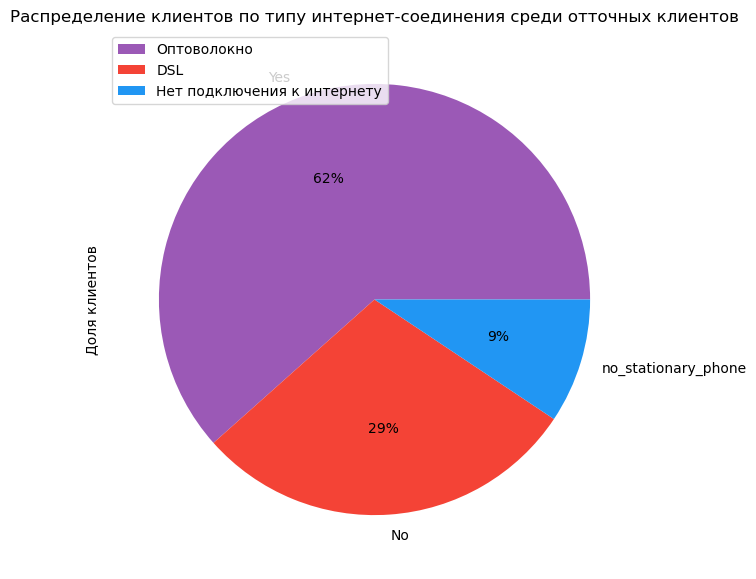

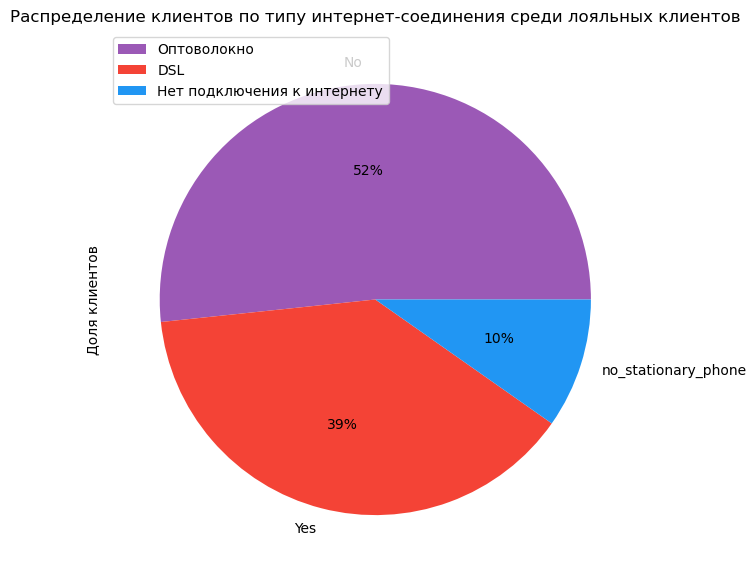

In [72]:
for i in [True, False]:
    df.loc[df['churned'] == i, 'multiple_lines'].value_counts().plot(
        kind='pie', autopct='%1.f%%', figsize=(7, 7), colors=colors)
    if i == True:
        title = 'Распределение клиентов по типу интернет-соединения среди отточных клиентов'
    else:
        title = 'Распределение клиентов по типу интернет-соединения среди лояльных клиентов'
    plt.ylabel('Доля клиентов')
    plt.legend(labels=['Оптоволокно','DSL','Нет подключения к интернету'])
    plt.title(title)
    plt.show()
    print()

Среди отточных клиентов доля подключения по оптоволокну на 10% выше, чем среди лояльных клиентов,

### *Распределение пользователей между 2я флагманскими услугами*

У Компании имеется 2е услуги-флагмана (стационарная телефонная связь и подключение к интернет-сети). Исследуем как влияет пересечение этих услуг среди групп пользователей ловяльных и нет.

In [73]:
def flagman_usage(row):
    if row['multiple_lines']!='no_stationary_phone' and row['internet_service']!='no_internet_service':
        return 'phone & internet'
    elif row['multiple_lines']!='no_stationary_phone' and row['internet_service']=='no_internet_service':
        return 'only phone'
    elif row['multiple_lines']=='no_stationary_phone' and row['internet_service']!='no_internet_service':
        return 'only internet'

In [74]:
df['flagmans'] = df.apply(flagman_usage, axis=1)

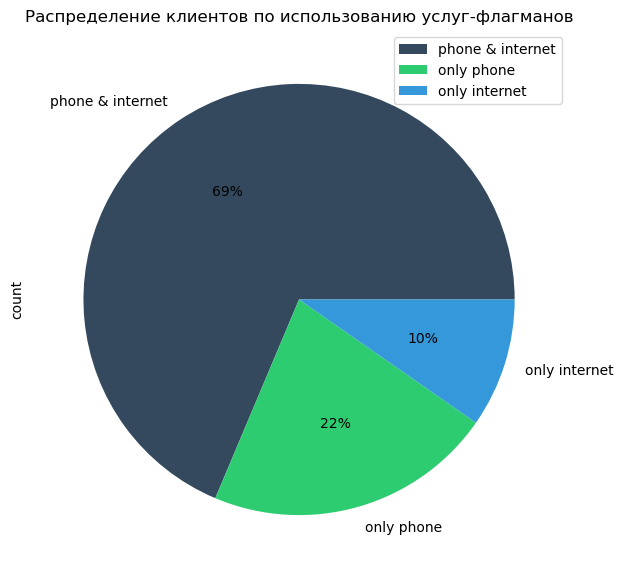

In [75]:
colors = ['#34495E', '#2ECC71', '#3498DB']
df['flagmans'].value_counts().plot(
    kind='pie', autopct='%1.f%%', figsize=(15, 7), colors=colors)
plt.title('Распределение клиентов по использованию услуг-флагманов')
plt.legend()

plt.show()


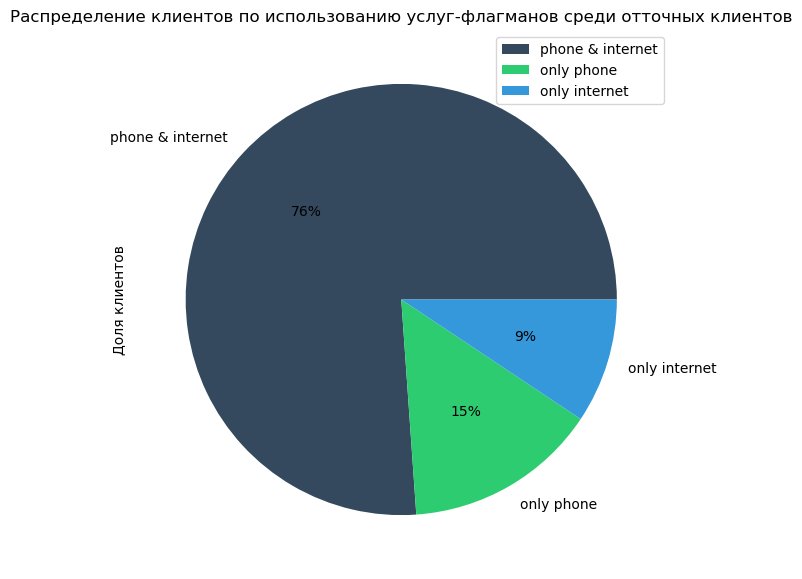

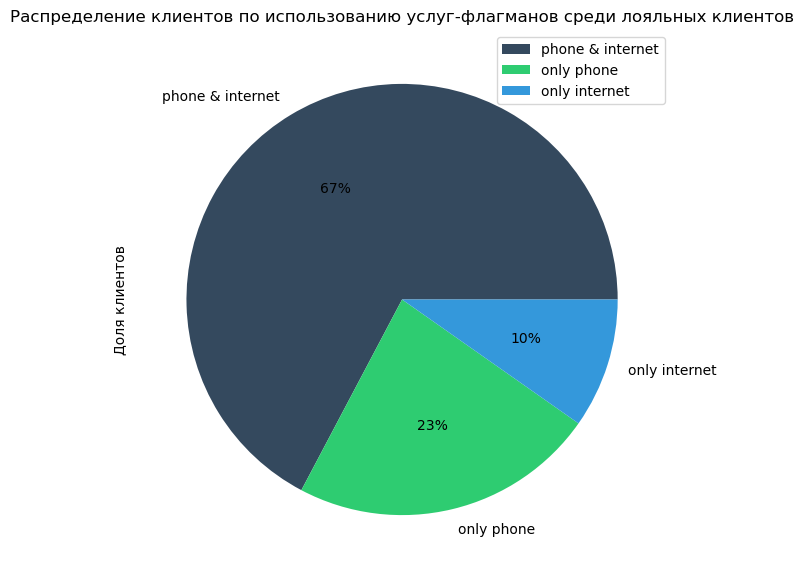

In [76]:
for i in [True, False]:
    df.loc[df['churned'] == i, 'flagmans'].value_counts().plot(
        kind='pie', autopct='%1.f%%', figsize=(7, 7), colors=colors)
    if i == True:
        title = 'Распределение клиентов по использованию услуг-флагманов среди отточных клиентов'
    else:
        title = 'Распределение клиентов по использованию услуг-флагманов среди лояльных клиентов'
    plt.ylabel('Доля клиентов')
    plt.legend()
    plt.title(title)
    plt.show()
    print()

Среди нелояльных клиентов доля клиентов испольующих обе флагмансие услуги выше, чем среди лояльных клиентов.

## Дополнительные услуги

### *online_security*

In [77]:
df.pivot_table(index = 'churned', columns='online_security', values='customer_id', aggfunc='count')


online_security,No,Yes
churned,,
False,4338,1604
True,686,415


### *online_backup*

In [78]:
df.pivot_table(index = 'churned', columns='online_backup', values='customer_id', aggfunc='count')

online_backup,No,Yes
churned,,
False,4073,1869
True,541,560


### *device_protection*

In [79]:
df.pivot_table(index = 'churned', columns='device_protection', values='customer_id', aggfunc='count')

device_protection,No,Yes
churned,,
False,4070,1872
True,551,550


### *tech_support*

In [80]:
df.pivot_table(index = 'churned', columns='tech_support', values='customer_id', aggfunc='count')

tech_support,No,Yes
churned,,
False,4296,1646
True,703,398


### *streaming_tv*

In [81]:
df.pivot_table(index = 'churned', columns='streaming_tv', values='customer_id', aggfunc='count')

streaming_tv,No,Yes
churned,,
False,3819,2123
True,517,584


### *streaming_movies*

In [82]:
df.pivot_table(index = 'churned', columns='streaming_movies', values='customer_id', aggfunc='count')

streaming_movies,No,Yes
churned,,
False,3816,2126
True,495,606


Для всех дополнительных услуг будет верным утверждение, что чаще всего, клиенты, отказывающиеся от услуг компании их не используют. 

## Исследование дисбаланса класса оттока клиентов

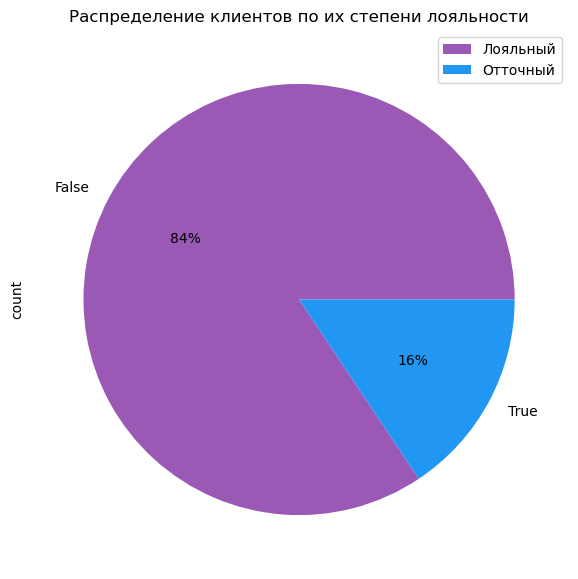

In [83]:
colors = ['#9B59B6', '#2196F3']
df['churned'].value_counts().plot(
    kind='pie', autopct='%1.f%%', figsize=(15, 7), colors=colors)
plt.title('Распределение клиентов по их степени лояльности')
plt.legend(labels=['Лояльный','Отточный'])

plt.show()


В целевой переменной наблюдается сильный дисбаланс: при обучении моделей его стоит иметь в виду и использовать один из методов борьбы. 

## ***Выводы***

В нашем рапоряжении данные 7043 клиентов оператора связи «Ниединогоразрыва.ком».


Компания в 2019 году привлекла почти вдвое больше клиентов, чем в каждом из 4 предыдущих. За последние годы дейятельности компании можно отметить рост кол-ва оттекающих клиентов от года к году,при стабильно увеличивающемся кол-ве активных клиентов компании мы можем отметить заметный рост % оттока клиентов в 2017 году и сохранением этой тенденции в следующем году. В 2019 году было заметное снижение % оттока клиентов относительно всех активных абонентов.

В 25% случаях, клиенты решающие отказаться от услуг компании делают это в течение 1го года, а половина оттекающих клиентов делают это спустя не более 2.5 лет.

Среди активных клиентов (на момент составления отчета) более 75% являются клиентами не  менее полутора лет, а половина клиентов сотрудничают с компанией уже почти два года.


Более половины всех клиентов предпочитают платить за выбранные услуги помесячно продлевая договор. Оставшиеся 45% почти в равных долях выбирают заключать договор на один год или на два. 

Как для всех типов клиентов (лояльных и отточных) вместе и по отдельности предпочтения по способу выставления счета практически не отличаются, из чего можно сделать вывод, что данная переменная будет не самой инорфмативной для прогноза вероятности оттока клиента. 
44% Клиентов предпочитают автоматизировать оплату услуг компании. В целом все 4е способа оплаты имеют почти равную популярность среди клиентов (на 10% от всех остальных отрывается Электронный чек)


Лояльные клиенты в 40% случаев предпочитают автоматизировать оплату своих счетов. А клиенты, которые в итоге оттекли - в 58% случаев предпочитали автоматизацию, только в 10% - оплачивали по почте.

Ежемесячная плата для всех клиентов варьируется от 18у.е. дло 118.
25% клиентов ещемесячно платят не менее 23у.е. А вероятностью равной 95% мы можем утверждать, что при болеевысокой ежемесячной плате вероятность оттока клианта выше, чем при более низкой.

Не смотря на то, что некоторые клиенты отказываются от услуг компании внося более высокий ещемесячный платеж, в общую прибыль они вкладывают всего 18%, тогда как оставшаяся часть приходится на платежи лояльных клиентов компании.

Пол клиента не влияет на вероятность его отказа от услуг компании.

Всего 16% от всех клиентов уже достигли пенсионного возраста, а влияние пенсионного возраста на вероятность оттока клиентов незначительно.

Среди отточных клиентов доля одиноких клиентов выше, чем у лояльных

Наличие у клиента лиц на иждивении не влияет на вероятность его оттока.

Сравнивая отточных клиентов и лояльных - можно отметить тенденцию, что среди уходяхих чаще встречаются те, кто используют только один канал связи.
Среди отточных клиентов доля подключения по оптоволокну на 10% выше, чем среди лояльных клиентов,

Среди нелояльных клиентов доля клиентов использующих обе флагмансие услуги выше, чем среди лояльных клиентов.

Для всех дополнительных услуг будет верным утверждение, что чаще всего, клиенты, отказывающиеся от услуг компании их не используют. При необхомости снижения признакового пространства эти 6ть признаков можно будет заменить одним (использует ли клиент хоть одну доп. услугу) или двумя (1 - использованиехотя бы одной услуги, не связаной со стримингом 2 - использованиехотя бы одной услуги, связаной со стримингом )

В целевой переменной наблюдается сильный дисбаланс: при обучении моделей его стоит иметь в виду и использовать один из методов борьбы.

# Подготовка данных к обучению моделей

## Удаление неинформативных переменных + добавление новых

Чтобы сократить признаковое пространство перекодируем переменные относящиеся к дополнительным услугам в одну: сколькими дополнительными услугами пользуется клиент.

In [84]:
# функция для дополнительных услуг
def additionals(row):
    x=[ 
            row['online_security'] == "Yes",
            row['online_backup'] == "Yes",
            row['device_protection'] == "Yes",
            row['tech_support'] == "Yes",
            row['streaming_tv'] == "Yes",
            row['streaming_movies'] == "Yes"
    ]
    return sum(x)



In [85]:
df['additional'] = df.apply(additionals, axis=1)


In [86]:
df.pivot_table(index='churned', columns='additional',
               values='customer_id', aggfunc='count')

additional,0,1,2,3,4,5,6
churned,,,,,,,
False,2028,877,889,875,627,424,222
True,191,89,144,243,225,147,62


In [87]:
df = df.drop(['online_security',
              'online_backup',
              'device_protection',
              'tech_support',
              'streaming_tv',
              'streaming_movies'],
             axis=1)

Удалим таже неинформативные и временные переменные (нужны были для EDA)

In [88]:
df = df.drop(['customer_id',
              'begin_date',
              'end_date',
              'customer_id_low',
              'begin_year',
              'end_year',
              'flagmans'],
             axis=1)

## Проверка мультиколиннеарности признаков

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'lifetime', 'additional']


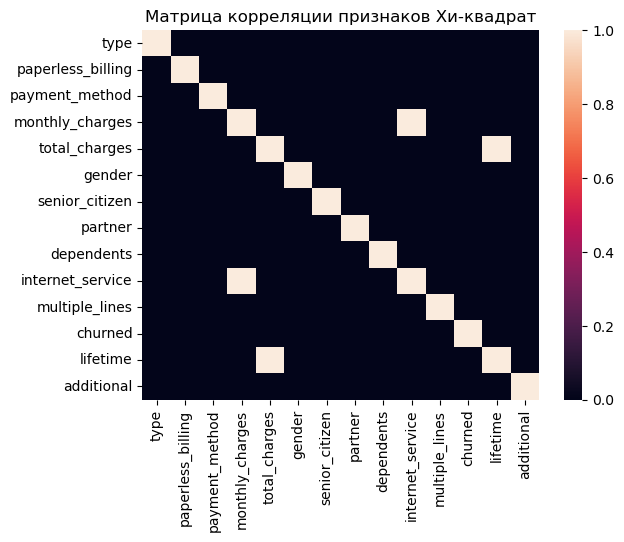

In [89]:
sns.heatmap(df.phik_matrix()>0.8)
plt.title('Матрица корреляции признаков Хи-квадрат')
plt.show()

Хи квадрат выше 0.8 мы наблюдаем между признаками:  LTV и lifetime и ежемесячными платами и использованием услуг по подключению в интернету. Чтобы побороть эту мультиколлинеарность я предлагаю создать вычисляемую пременную: средняя фактическая плата (LTV/lifetime) - которая позволит удалить и motnhly charges  и  total charges.

In [90]:
def fact_regular_payment(row):
    if row['lifetime'] ==0:
        return round(row['monthly_charges']/30,2)
    else:
        return round(row['total_charges']/row['lifetime'],2)
    

In [91]:
df['fact_reg_pay'] = df.apply(fact_regular_payment, axis =1)

In [92]:
df[['monthly_charges','fact_reg_pay']].corr()

,monthly_charges,fact_reg_pay
monthly_charges,1.000000,0.996899
fact_reg_pay,0.996899,1.000000


In [93]:
df = df.drop(['total_charges','monthly_charges'], axis=1)

interval columns not set, guessing: ['senior_citizen', 'lifetime', 'additional', 'fact_reg_pay']


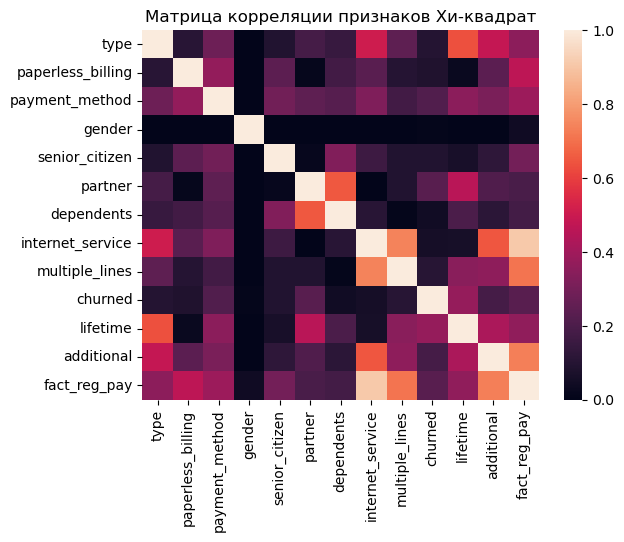

In [94]:
sns.heatmap(df.phik_matrix())
plt.title('Матрица корреляции признаков Хи-квадрат')
plt.show()

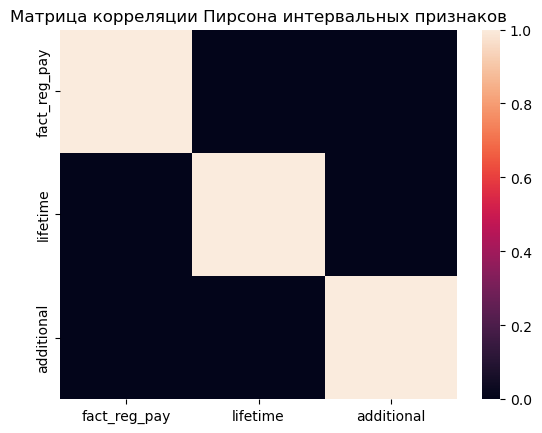

In [95]:
sns.heatmap(df[['fact_reg_pay','lifetime','additional']].corr()>0.8)
plt.title('Матрица корреляции Пирсона интервальных признаков')
plt.show()

Высокая линейная скоррелированность численных признаков отсуствует.

## Проверка наличия дубликатов

In [96]:
df.duplicated().sum()

87

In [97]:
df = df.drop_duplicates()

In [98]:
df.columns

Index(['type', 'paperless_billing', 'payment_method', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'multiple_lines', 'churned', 'lifetime', 'additional', 'fact_reg_pay'],
      dtype='object')

Также для дальнейшего удобства создадим две константые переменные с указаднием категориальных и численных нецелевых переменных.

In [99]:
CATEGORICAL = ['type', 'paperless_billing', 'payment_method',
               'gender', 'senior_citizen', 'partner', 'dependents',
               'multiple_lines','internet_service']
NUMERICAL = [ 'fact_reg_pay',  'lifetime','additional']

In [100]:
len(df.columns)-1 ==(len(CATEGORICAL)+len(NUMERICAL))

True

## Разделение выборки на тестовую и обучающую

Выделим целевую и нецелевые переменные.

In [101]:
target = df['churned']
features = df.drop(['churned'], axis=1)

Разделим выборку на обучающую и тестовую. Обучающая будет использоваться далее без разделения на обучающую и валидационную - обучение моделей будет производиться с помощью кросс-валидации. Так как в целевой переменной наблюдается большой дисбаланс - используем параметр stratify чтобы убедиться чтобы в тестовой выборке баланс был такой же как в генеральной совокупности.

In [102]:
RANDOM_STATE = 80523

In [103]:
train_features, test_features, train_target, test_target =\
    train_test_split(features, target, test_size=0.25,
                     random_state=RANDOM_STATE, stratify=target)

In [104]:
len(features)

6956

## Подготовка пайплайнов

In [105]:
# Задаем пайплайн стандартизатора
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

In [106]:
# Задаем пайплайн перекодировки OHE
categorical_transformer_ohe = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore',drop='first'))])

In [107]:
# Задаем пайплайн перекодировки OE
categorical_transformer_oe = Pipeline(steps=[
    ('oe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

In [108]:
# сформируем препроцессор c  OHE
preprocessor_ohe = ColumnTransformer(transformers=[
    ('num', numeric_transformer, NUMERICAL),
    ('cat', categorical_transformer_ohe, CATEGORICAL)])

In [109]:
# сформируем препроцессор c  OE
preprocessor_oe = ColumnTransformer(transformers=[
    ('num', numeric_transformer, NUMERICAL),
    ('cat', categorical_transformer_oe, CATEGORICAL)])

In [110]:
preprocessor_scaler = ColumnTransformer(transformers=[
    ('num', numeric_transformer, NUMERICAL)])

# Обучение моделей

In [111]:
COLS = ['Logistic Regression', 'Random Forest Classifier',
        'Catboost', 'XGBoost', 'LightGBM']
INDEX = ['SMOTE',  'Weight classes']
mat = np.zeros((2, 5))
AUC_ROC_scores = pd.DataFrame(mat, columns=COLS, index=INDEX)
BEST_PARAMS = pd.DataFrame(mat, columns=COLS, index=INDEX)
STRAT_K_FOLD_5 = StratifiedKFold(n_splits=3)

In [112]:
COLS = ['Logistic Regression_SMOTE', 'Random Forest Classifier_SMOTE',
        'Catboost_SMOTE', 'XGBoost_SMOTE', 'LightGBM_SMOTE','Logistic Regression_CW', 'Random Forest Classifier_CW',
        'Catboost_CW', 'XGBoost_CW', 'LightGBM_CW']
INDEX = ['FPR',  'TPR','ROC_AUC']
mat = np.zeros((3, 10))
ROC_CURVES = pd.DataFrame(mat, columns=COLS, index=INDEX)

## Используя увеличение миноритарного класса методом SMOTE


### logistic regression

In [113]:
clf = LogisticRegression(random_state=RANDOM_STATE,penalty='l2')
pipeline_up_ohe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_ohe),
    ('oversampler', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', clf)])

In [ ]:
python
params = {'classifier__max_iter': range(50,200,50),
          'classifier__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}


In [115]:
%%time
grid = GridSearchCV(estimator=pipeline_up_ohe,
                    param_grid=params,
                    scoring='roc_auc',
                    cv=STRAT_K_FOLD_5,
                    n_jobs=-1)
grid.fit(train_features, train_target)
AUC_ROC_scores['Logistic Regression']['SMOTE'] = grid.best_score_
BEST_PARAMS['Logistic Regression']['SMOTE'] = grid.best_params_

CPU times: user 339 ms, sys: 39.5 ms, total: 378 ms
Wall time: 649 ms


In [116]:
AUC_ROC_scores

,Logistic Regression,Random Forest Classifier,Catboost,XGBoost,LightGBM
SMOTE,0.748295,0.0,0.0,0.0,0.0
Weight classes,0.000000,0.0,0.0,0.0,0.0


In [117]:
clf = grid.best_estimator_

y_pred = cross_val_predict(clf,
                           train_features, 
                           train_target, 
                           cv=STRAT_K_FOLD_5, 
                           method='predict_proba')[:, 1]
LR_SM_fpr, LR_SM_tpr, thresholds = roc_curve(train_target, y_pred)
RL_SM_roc_auc = auc(LR_SM_fpr, LR_SM_tpr)


### Random Forest classifier

In [118]:
clf = RandomForestClassifier(random_state=RANDOM_STATE)

pipeline_up_oe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_oe),
    ('oversampler', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', clf)])

In [ ]:

params = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_depth': range(5, 16, 5),
    'classifier__n_estimators': range(50, 200, 25)
}


In [120]:
%%time
grid = GridSearchCV(estimator=pipeline_up_oe,
                    param_grid=params,
                    scoring='roc_auc',
                    cv=5,
                    n_jobs=-1)
grid.fit(train_features, train_target)
AUC_ROC_scores['Random Forest Classifier']['SMOTE'] = grid.best_score_
BEST_PARAMS['Random Forest Classifier']['SMOTE'] = grid.best_params_

CPU times: user 2.03 s, sys: 58.5 ms, total: 2.09 s
Wall time: 8.63 s


In [121]:
AUC_ROC_scores

,Logistic Regression,Random Forest Classifier,Catboost,XGBoost,LightGBM
SMOTE,0.748295,0.823117,0.0,0.0,0.0
Weight classes,0.000000,0.000000,0.0,0.0,0.0


In [122]:
clf = grid.best_estimator_

y_pred = cross_val_predict(clf,
                           train_features, 
                           train_target, 
                           cv=STRAT_K_FOLD_5, 
                           method='predict_proba')[:, 1]
RF_SM_fpr, RF_SM_tpr, thresholds = roc_curve(train_target, y_pred)
RF_SM_roc_auc = auc(RF_SM_fpr, RF_SM_tpr)

### Catboost classifier

In [123]:
train_target_cb = train_target.copy().astype('int')


In [124]:
clf = CatBoostClassifier(random_state=RANDOM_STATE)

pipeline_up_oe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_oe),
    ('oversampler', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', clf)])

In [ ]:

params = {
    'classifier__max_depth': range(5, 16, 5),
    'classifier__n_estimators': range(50, 200, 50)
}


In [126]:
%%time
grid = GridSearchCV(estimator=pipeline_up_oe,
                    param_grid=params,
                    scoring='roc_auc',
                    cv=STRAT_K_FOLD_5,
                    n_jobs=-1)
grid.fit(train_features, train_target_cb, classifier__verbose = False)
AUC_ROC_scores['Catboost']['SMOTE'] = grid.best_score_
BEST_PARAMS['Catboost']['SMOTE'] = grid.best_params_

CPU times: user 908 ms, sys: 84.7 ms, total: 993 ms
Wall time: 3.21 s


In [127]:
AUC_ROC_scores

,Logistic Regression,Random Forest Classifier,Catboost,XGBoost,LightGBM
SMOTE,0.748295,0.823117,0.839412,0.0,0.0
Weight classes,0.000000,0.000000,0.000000,0.0,0.0


In [128]:
clf = grid.best_estimator_

y_pred = cross_val_predict(clf,
                           train_features, 
                           train_target, 
                           cv=STRAT_K_FOLD_5, 
                           method='predict_proba')[:, 1]
CB_SM_fpr, CB_SM_tpr, thresholds = roc_curve(train_target, y_pred)
CB_SM_roc_auc = auc(CB_SM_fpr, CB_SM_tpr)

Learning rate set to 0.124785
0:	learn: 0.6534757	total: 3.77ms	remaining: 561ms
1:	learn: 0.6183619	total: 6.43ms	remaining: 476ms
2:	learn: 0.5892157	total: 9.32ms	remaining: 456ms
3:	learn: 0.5660291	total: 12.5ms	remaining: 457ms
4:	learn: 0.5465493	total: 15.3ms	remaining: 443ms
5:	learn: 0.5300015	total: 18ms	remaining: 433ms
6:	learn: 0.5153338	total: 21.2ms	remaining: 433ms
7:	learn: 0.5026547	total: 24ms	remaining: 426ms
8:	learn: 0.4905998	total: 27ms	remaining: 423ms
9:	learn: 0.4802600	total: 29.8ms	remaining: 417ms
10:	learn: 0.4713269	total: 32.6ms	remaining: 411ms
11:	learn: 0.4640949	total: 35.9ms	remaining: 413ms
12:	learn: 0.4554726	total: 39.2ms	remaining: 414ms
13:	learn: 0.4476142	total: 43.4ms	remaining: 422ms
14:	learn: 0.4425498	total: 47.7ms	remaining: 430ms
15:	learn: 0.4363552	total: 53.5ms	remaining: 448ms
16:	learn: 0.4311825	total: 60.1ms	remaining: 470ms
17:	learn: 0.4256427	total: 64.7ms	remaining: 475ms
18:	learn: 0.4206081	total: 68.8ms	remaining: 474m

### XGBoost classifier

In [129]:
clf = XGBClassifier(random_state=RANDOM_STATE)

pipeline_up_oe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_oe),
    ('oversampler', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', clf)])

In [ ]:

params = {
 'classifier__learning_rate': [0.03, 0.1],
 'classifier__max_depth': range(5, 16, 5),
 'classifier__max_leaves': range(5,50,10),
 'classifier__n_estimators': range(50, 200, 50)
}


In [131]:
%%time
grid = GridSearchCV(estimator=pipeline_up_oe,
                    param_grid=params,
                    scoring='roc_auc',
                    cv=STRAT_K_FOLD_5,
                    n_jobs=-1)
grid.fit(train_features, train_target)
AUC_ROC_scores['XGBoost']['SMOTE'] = grid.best_score_
BEST_PARAMS['XGBoost']['SMOTE'] = grid.best_params_

CPU times: user 5.75 s, sys: 144 ms, total: 5.89 s
Wall time: 8.27 s


In [132]:
AUC_ROC_scores

,Logistic Regression,Random Forest Classifier,Catboost,XGBoost,LightGBM
SMOTE,0.748295,0.823117,0.839412,0.863564,0.0
Weight classes,0.000000,0.000000,0.000000,0.000000,0.0


In [133]:
clf = grid.best_estimator_

y_pred = cross_val_predict(clf,
                           train_features, 
                           train_target, 
                           cv=STRAT_K_FOLD_5, 
                           method='predict_proba')[:, 1]
XGB_SM_fpr, XGB_SM_tpr, thresholds = roc_curve(train_target, y_pred)
XGB_SM_roc_auc = auc(XGB_SM_fpr, XGB_SM_tpr)

### LGBMClassifier

In [134]:
clf = lgb.LGBMClassifier(random_state=RANDOM_STATE)

pipeline_up_oe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_oe),
    ('oversampler', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', clf)])

In [ ]:

params = {
'classifier__learning_rate': [0.03, 0.1],
 'classifier__max_depth': range(5, 16, 5),
 'classifier__n_estimators': range(50, 200, 50)
}


In [136]:
%%time
grid = GridSearchCV(estimator=pipeline_up_oe,
                    param_grid=params,
                    scoring='roc_auc',
                    cv=STRAT_K_FOLD_5,
                    n_jobs=-1)
grid.fit(train_features, train_target)
AUC_ROC_scores['LightGBM']['SMOTE'] = grid.best_score_
BEST_PARAMS['LightGBM']['SMOTE'] = grid.best_params_

CPU times: user 989 ms, sys: 33.8 ms, total: 1.02 s
Wall time: 1.03 s


In [137]:
AUC_ROC_scores

,Logistic Regression,Random Forest Classifier,Catboost,XGBoost,LightGBM
SMOTE,0.748295,0.823117,0.839412,0.863564,0.878651
Weight classes,0.000000,0.000000,0.000000,0.000000,0.000000


In [138]:
clf = grid.best_estimator_

y_pred = cross_val_predict(clf,
                           train_features, 
                           train_target, 
                           cv=STRAT_K_FOLD_5, 
                           method='predict_proba')[:, 1]
LGB_SM_fpr, LGB_SM_tpr, thresholds = roc_curve(train_target, y_pred)
LGB_SM_roc_auc = auc(LGB_SM_fpr, LGB_SM_tpr)

## Используя параметр модели class_weight


### logistic regression

In [139]:
clf = LogisticRegression(random_state=RANDOM_STATE,class_weight = 'balanced')
pipeline_ohe = Pipeline(steps=[
    ('preprocessor', preprocessor_ohe),
    ('classifier', clf)])

In [ ]:

params = {'classifier__max_iter': range(50,200,50),
          'classifier__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}


In [141]:
%%time
grid = GridSearchCV(estimator=pipeline_up_ohe,
                    param_grid=params,
                    scoring='roc_auc',
                    cv=STRAT_K_FOLD_5,
                    n_jobs=-1)
grid.fit(train_features, train_target)
AUC_ROC_scores['Logistic Regression']['Weight classes'] = grid.best_score_
BEST_PARAMS['Logistic Regression']['Weight classes'] = grid.best_params_

CPU times: user 236 ms, sys: 22.1 ms, total: 258 ms
Wall time: 324 ms


In [142]:
AUC_ROC_scores

,Logistic Regression,Random Forest Classifier,Catboost,XGBoost,LightGBM
SMOTE,0.748295,0.823117,0.839412,0.863564,0.878651
Weight classes,0.748298,0.000000,0.000000,0.000000,0.000000


In [143]:
clf = grid.best_estimator_

y_pred = cross_val_predict(clf,
                           train_features, 
                           train_target, 
                           cv=STRAT_K_FOLD_5, 
                           method='predict_proba')[:, 1]
LR_CW_fpr, LR_CW_tpr, thresholds = roc_curve(train_target, y_pred)
LR_CW_roc_auc = auc(LR_CW_fpr, LR_CW_tpr)

### Random Forest classifier

In [144]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

pipeline_ohe = Pipeline(steps=[
    ('preprocessor', preprocessor_ohe),
    ('classifier', clf)])

In [ ]:

params = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_depth': range(5, 16, 5),
    'classifier__n_estimators': range(50, 200, 25)
}


In [146]:
%%time
grid = GridSearchCV(estimator=pipeline_ohe,
                    param_grid=params,
                    scoring='roc_auc',
                    cv=STRAT_K_FOLD_5,
                    n_jobs=-1)
grid.fit(train_features, train_target)
AUC_ROC_scores['Random Forest Classifier']['Weight classes'] = grid.best_score_
BEST_PARAMS['Random Forest Classifier']['Weight classes'] = grid.best_params_

CPU times: user 989 ms, sys: 40.5 ms, total: 1.03 s
Wall time: 2.59 s


In [147]:
AUC_ROC_scores

,Logistic Regression,Random Forest Classifier,Catboost,XGBoost,LightGBM
SMOTE,0.748295,0.823117,0.839412,0.863564,0.878651
Weight classes,0.748298,0.821636,0.000000,0.000000,0.000000


In [148]:
clf = grid.best_estimator_

y_pred = cross_val_predict(clf,
                           train_features, 
                           train_target, 
                           cv=STRAT_K_FOLD_5, 
                           method='predict_proba')[:, 1]
RF_CW_fpr, RF_CW_tpr, thresholds = roc_curve(train_target, y_pred)
RF_CW_roc_auc = auc(RF_CW_fpr, RF_CW_tpr)

### catboost classifier

In [149]:
classes = np.unique(train_target_cb)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_target_cb)
class_weights = dict(zip(classes, weights))

In [150]:
clf = CatBoostClassifier(random_state=RANDOM_STATE,class_weights=class_weights)

pipeline_oe = Pipeline(steps=[
    ('preprocessor', preprocessor_oe),
    ('classifier', clf)])

In [ ]:

params = {
   'classifier__learning_rate': [0.03, 0.1],
    'classifier__max_depth': range(5, 16, 5),
    'classifier__n_estimators': range(50, 200, 50)
}


In [152]:
%%time
grid = GridSearchCV(estimator=pipeline_oe,
                    param_grid=params,
                    scoring='roc_auc',
                    cv=STRAT_K_FOLD_5,
                    n_jobs=-1)
grid.fit(train_features, train_target_cb, classifier__verbose=False)
AUC_ROC_scores['Catboost']['Weight classes'] = grid.best_score_
BEST_PARAMS['Catboost']['Weight classes'] = grid.best_params_

CPU times: user 449 ms, sys: 83.3 ms, total: 532 ms
Wall time: 1.62 s


In [153]:

AUC_ROC_scores

,Logistic Regression,Random Forest Classifier,Catboost,XGBoost,LightGBM
SMOTE,0.748295,0.823117,0.839412,0.863564,0.878651
Weight classes,0.748298,0.821636,0.841486,0.000000,0.000000


In [154]:
clf = grid.best_estimator_

y_pred = cross_val_predict(clf,
                           train_features, 
                           train_target, 
                           cv=STRAT_K_FOLD_5, 
                           method='predict_proba')[:, 1]
CB_CW_fpr, CB_CW_tpr, thresholds = roc_curve(train_target, y_pred)
CB_CW_roc_auc = auc(CB_CW_fpr, CB_CW_tpr)

0:	learn: 0.6680419	total: 1.67ms	remaining: 249ms
1:	learn: 0.6480456	total: 3.33ms	remaining: 247ms
2:	learn: 0.6305601	total: 4.8ms	remaining: 235ms
3:	learn: 0.6150856	total: 6.3ms	remaining: 230ms
4:	learn: 0.6015535	total: 7.74ms	remaining: 225ms
5:	learn: 0.5902187	total: 9.22ms	remaining: 221ms
6:	learn: 0.5784754	total: 10.6ms	remaining: 217ms
7:	learn: 0.5691029	total: 12.1ms	remaining: 215ms
8:	learn: 0.5593073	total: 13.6ms	remaining: 213ms
9:	learn: 0.5515541	total: 15.2ms	remaining: 213ms
10:	learn: 0.5454952	total: 16.7ms	remaining: 211ms
11:	learn: 0.5390586	total: 18.4ms	remaining: 211ms
12:	learn: 0.5341111	total: 19.8ms	remaining: 209ms
13:	learn: 0.5286132	total: 20.8ms	remaining: 202ms
14:	learn: 0.5245313	total: 21.7ms	remaining: 195ms
15:	learn: 0.5204784	total: 22.6ms	remaining: 189ms
16:	learn: 0.5159565	total: 23.4ms	remaining: 183ms
17:	learn: 0.5114902	total: 24.3ms	remaining: 178ms
18:	learn: 0.5082565	total: 25.2ms	remaining: 174ms
19:	learn: 0.5045882	tot

### XGBoost classifier

In [155]:

SCALE_POS_WEIGHT = round(sum(train_target==False)/sum(train_target==True))

In [156]:
clf = XGBClassifier(random_state=RANDOM_STATE,scale_pos_weight = SCALE_POS_WEIGHT)

pipeline_oe = Pipeline(steps=[
    ('preprocessor', preprocessor_oe),
    
    ('classifier', clf)])

In [ ]:
params = {
 'classifier__max_depth': range(5, 16, 5),
 'classifier__max_leaves': range(5,50,10),
 'classifier__n_estimators': range(50, 200, 50)
}


In [158]:
%%time
grid = GridSearchCV(estimator=pipeline_oe,
                    param_grid=params,
                    scoring='roc_auc',
                    cv=STRAT_K_FOLD_5,
                    n_jobs=-1)
grid.fit(train_features, train_target)#, classifier__verbose=None)
AUC_ROC_scores['XGBoost']['Weight classes'] = grid.best_score_
BEST_PARAMS['XGBoost']['Weight classes'] = grid.best_params_

CPU times: user 1.52 s, sys: 23 ms, total: 1.54 s
Wall time: 1.3 s


In [159]:
AUC_ROC_scores

,Logistic Regression,Random Forest Classifier,Catboost,XGBoost,LightGBM
SMOTE,0.748295,0.823117,0.839412,0.863564,0.878651
Weight classes,0.748298,0.821636,0.841486,0.893153,0.000000


In [160]:
clf = grid.best_estimator_

y_pred = cross_val_predict(clf,
                           train_features, 
                           train_target, 
                           cv=STRAT_K_FOLD_5, 
                           method='predict_proba')[:, 1]
XGB_CW_fpr, XGB_CW_tpr, thresholds = roc_curve(train_target, y_pred)
XGB_CW_roc_auc = auc(XGB_CW_fpr, XGB_CW_tpr)

### LightGBM classifier

In [161]:
clf = lgb.LGBMClassifier(random_state=RANDOM_STATE,class_weight='balanced')

pipeline_down_oe = Pipeline(steps=[
    ('preprocessor', preprocessor_oe),
    ('classifier', clf)])

In [ ]:

params = {
'classifier__learning_rate': [0.03, 0.1],
 
 'classifier__max_leaves': range(5,50,10),
 'classifier__n_estimators': range(50, 200, 25)
}


In [163]:
%%time
grid = GridSearchCV(estimator=pipeline_down_oe,
                    param_grid=params,
                    scoring='roc_auc',
                    cv=STRAT_K_FOLD_5,
                    n_jobs=-1)
grid.fit(train_features, train_target)
AUC_ROC_scores['LightGBM']['Weight classes'] = grid.best_score_
BEST_PARAMS['LightGBM']['Weight classes'] = grid.best_params_

[LightGBM] [Warning] num_leaves is set=31, max_leaves=5 will be ignored. Current value: num_leaves=31
CPU times: user 722 ms, sys: 39.6 ms, total: 761 ms
Wall time: 778 ms


In [164]:
clf = grid.best_estimator_

y_pred = cross_val_predict(clf,
                           train_features, 
                           train_target, 
                           cv=STRAT_K_FOLD_5, 
                           method='predict_proba')[:, 1]
LGB_CW_fpr, LGB_CW_tpr, thresholds = roc_curve(train_target, y_pred)
LGB_CW_roc_auc = auc(LGB_CW_fpr, LGB_CW_tpr)

[LightGBM] [Warning] num_leaves is set=31, max_leaves=5 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_leaves is set=31, max_leaves=5 will be ignored. Current value: num_leaves=31


## Выбор наилучшей модели

In [165]:
AUC_ROC_scores

,Logistic Regression,Random Forest Classifier,Catboost,XGBoost,LightGBM
SMOTE,0.748295,0.823117,0.839412,0.863564,0.878651
Weight classes,0.748298,0.821636,0.841486,0.893153,0.871754


Модель, с наилучшей метрикой AUC-ROC(c небольшим отрывом): XGBoost со встроенным способом борьбы с дисбалансом. Далее протестируем модель на тестовой выборкой и проанализируем получившийся результат.

Проанализируем кривые ROC для 4х моделей лидеров.

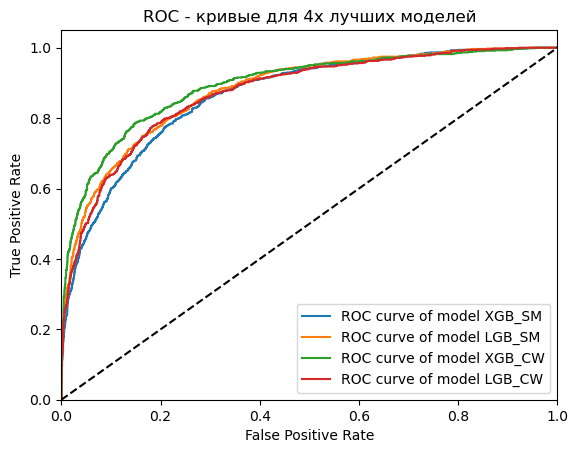

[LightGBM] [Warning] num_leaves is set=31, max_leaves=5 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_leaves is set=31, max_leaves=5 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_leaves is set=31, max_leaves=5 will be ignored. Current value: num_leaves=31


In [170]:
plt.plot(XGB_SM_fpr, XGB_SM_tpr, label='ROC curve of model XGB_SM' % XGB_SM_roc_auc)
plt.plot(LGB_SM_fpr, LGB_SM_tpr, label='ROC curve of model LGB_SM' % LGB_SM_roc_auc)
plt.plot(XGB_CW_fpr, XGB_CW_tpr, label='ROC curve of model XGB_CW' % XGB_CW_roc_auc)
plt.plot(LGB_CW_fpr, LGB_CW_tpr, label='ROC curve of model LGB_CW' % LGB_CW_roc_auc)


# Включите легенду и название графика
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - кривые для 4х лучших моделей')
plt.legend(loc="lower right")
plt.show()

Геометрия кривых +- одинаковая для всех моделей, Качество XGBM  при встроенной балансировке классов заметно увеличение площади под кривой. Для всех заметен сдвиг кривой влево.

# Проверка модели на тестовой выборке

In [171]:
BEST_PARAMS['XGBoost']['Weight classes']

{'classifier__max_depth': 5,
 'classifier__max_leaves': 5,
 'classifier__n_estimators': 150}

In [172]:
SCALE_POS_WEIGHT = round(sum(train_target==False)/sum(train_target==True))
clf = XGBClassifier(random_state=RANDOM_STATE,
                    scale_pos_weight = SCALE_POS_WEIGHT,
                   max_depth = 5,
                   max_leaves=5,
                   n_estimators= 150)


In [174]:
preprocessor = preprocessor_oe
preprocessor.fit(train_features)
train_feat_fin = preprocessor.transform(train_features)
test_feat_fin = preprocessor.transform(test_features)

In [175]:
clf.fit(train_feat_fin,train_target)
pred_proba = clf.predict_proba(test_feat_fin)[:, 1]
prediction = clf.predict(test_feat_fin)

In [176]:
print(f'''Метрика AUC-ROC для финальной модели составила: {round(roc_auc_score(test_target, pred_proba),2)}''')
print(f'''Метрика Accuracy для финальной модели составила:{round(accuracy_score(test_target, prediction),2)}''')



Метрика AUC-ROC для финальной модели составила: 0.91
Метрика Accuracy для финальной модели составила:0.9


На тестовой выборке показала даже лучший результат, чем при кросс-валидации на обучающей, что говорит об отсутствии у нее факта переобучения. Accuracy составила 0.9, что означает, что 90% модели точны. Посмотрим матрицу ошибок: 

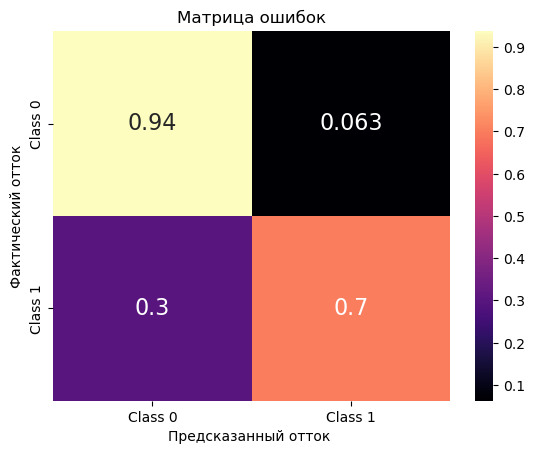

In [179]:
matrix = confusion_matrix(test_target, prediction)
normalized_cm = matrix / matrix.sum(axis=1)[:, np.newaxis]


sns.heatmap(normalized_cm, annot=True, annot_kws={"size": 16}, cmap='magma')
plt.xlabel('Предсказанный отток ')
plt.ylabel('Фактический отток')
plt.title('Матрица ошибок')
plt.xticks(ticks=[0.5, 1.5], labels=["Class 0", "Class 1"])
plt.yticks(ticks=[0.5, 1.5], labels=["Class 0", "Class 1"])
plt.show()

Предсказания модели, просигнализирует нам о 73% потенциально отточных клиентов (считая от всех клиентов, склонных к оттоку). Соотвественно при среднем оттоке равном 15% компания сможет удержать до 11% клиентов, что при клиентской базе в 7к клиентов может позволить компании повысить вуручку на почти 50к у.е. в месяц (7к клиентов * 11% *65у.е- средний ежемесячный платеж). 

Однако, стоит отмметить, что 30% плиентов, отмеченных моделью как отткающиее - таковыми не яляются, и компания будет нести издержки - предлагая этим клиентам скидку или бонусы. Однако если всего клиентов 7к,и при примерной скидке в 15% пиздержки составят:7к клиентов %15* * 30% * (65еу*15%) = составит около 3к уе в месяц, что незначительно пр потенциальнойй выгоде

## Оценка важности признаков

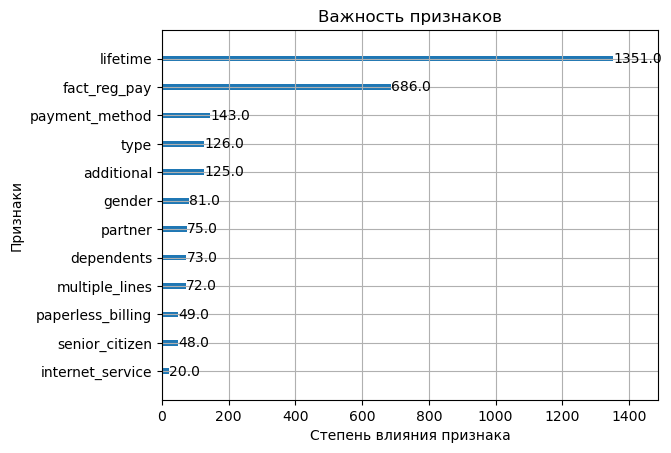

In [218]:
booster = clf.get_booster()
importance = booster.get_score()
#так как в модель передавались данные, трансформированные column trans
#изменим словарь, заменив ключи на исходные названия переменных
i=0
importance_new ={}
all_feat = [*NUMERICAL,*CATEGORICAL]
for key in importance.keys():
    importance_new[all_feat[i]] = importance[key]
    i+=1
    
    

ax = plot_importance(importance_new, show_values=True,
                     title ='Важность признаков',
                     xlabel='Степень влияния признака',
                     ylabel ='Признаки')
                    



При анализе важности признаков модели самым важными фактором является сколько пользователь является клиентом компании.Так как на него компания напрямую не может иметь влияния - то он может быть некоторым дополнительным элементом анализа каждого конкретного клиента. Как было ранее отмечена в EDA: самым рискованым периодом являетсят 1.5 до 5 лет - тут самы высокий рис оттока.


Так же важным фактором, влияющим на вероятность оттока является ежемесячная плата. Я бы рекомендовала бизнесу пытаться удержать клиента влияя именно на размер абонентской платы путем предоставления скидки.


# Общие выводы

## Подготовка данных

В ходе проведения первичной предобработки данных мною было проведена проверка на сквозную идентификацию пользователей в имеющихся данных из разных источников с последующим объединением их. Также я произвела переименование столбцов/переменных в стиле snake_makе. В данных не было выявлено ни явных ни неявных дубликатов. Также мною были добавленные новые столбцы с данными: "время жизни" клиента и факт его отказа от услуг компании. Данные приведены к необходимым форматам.

## Исследовательский анализ

За последние годы деятельности компании можно отметить рост кол-ва оттекающих клиентов от года к году,при стабильно увеличивающемся кол-ве активных клиентов компании мы можем отметить заметный рост % оттока клиентов в 2017 году и сохранением этой тенденции в следующем году.
В 2019 году было заметное снижение % оттока клиентов относительно всех активных абонентов.

В 25% случаях, клиенты решающие отказаться от услуг компании делают это в течение 1го года, а половина оттекающих клиентов делают это спустя не более 2.5 лет.
Среди активных клиентов (на момент составления отчета) более 75% являются клиентами не менее полутора лет, а половина клиентов сотрудничают с компанией уже почти два года.


Более половины всех клиентов предпочитают платить за выбранные услуги помесячно продлевая договор. Оставшиеся 45% почти в равных долях выбирают заключать договор на один год или на два.

Лояльные клиенты в 40% случаев предпочитают автоматизировать оплату своих счетов. А клиенты, которые в итоге оттекли - в 58% случаев предпочитали автоматизацию, только в 10% - оплачивали по почте.

Не смотря на то, что некоторые клиенты отказываются от услуг компании внося более высокий ещемесячный платеж, в общую прибыль они вкладывают всего 18%, тогда как оставшаяся часть приходится на платежи лояльных клиентов компании.

Среди отточных клиентов доля одиноких клиентов выше, чем у лояльных, наличие у клиента лиц на иждивении не влияет на вероятность его оттока.

Сравнивая отточных клиентов и лояльных - можно отметить тенденцию, что среди уходяхих чаще встречаются те, кто используют только один канал связи. Среди отточных клиентов доля подключения по оптоволокну на 10% выше, чем среди лояльных клиентов.

Среди нелояльных клиентов доля клиентов использующих обе флагмансие услуги выше, чем среди лояльных клиентов.
Для всех дополнительных услуг будет верным утверждение, что чаще всего, клиенты, отказывающиеся от услуг компании их не используют. При необхомости снижения признакового пространства эти 6ть признаков можно будет заменить одним (использует ли клиент хоть одну доп. услугу) или двумя (1 - использованиехотя бы одной услуги, не связаной со стримингом 2 - использованиехотя бы одной услуги, связаной со стримингом )


В целевой переменной наблюдается сильный дисбаланс: при обучении моделей его стоит иметь в виду и использовать один из методов борьбы.


## Подготовка данных к обучению

Чтобы сократить признаковое пространство были перекодированы переменные относящиеся к дополнительным услугам в одну: сколькими дополнительными услугами пользуется клиент.

При анализе взаимосвязей между переменными наблюдалась высокая взаимосвязь между признаками:  LTV и lifetime и ежемесячными платами и использованием услуг по подключению в интернету. Чтобы побороть эту мольтиколлинеарность была создана новая пременная: средняя фактическая плата (LTV/lifetime) - которая позволила удалить и motnhly charges  и  total charges.

## Обучение моделей

В ходе исследовательской части были обучены 5 моделей (Логистическая регрессия, Случайный лес, и 3и бустинга: Catboost, XGBoost, LightGBM) c двумя вариантами борьбы с дисбалансом классов (увеличение миноритарного класса методом SMOTE и встроенной в модели функцией class_weight). В кажом случае процесс был выстроен с помощью pipeline -в ходе которого проводилась стандартизация численных признаков и перекодирование категориальных. Для каждой модели производился подбор гиперпараметров с цель максимизировать auc-roc- метрику.

Модель-победитель XGBoost со встроенной балансировкой классов, с максимальной глубиной5, максимальным кол-вом листов 5 и кол-вом эстиматоров 150.

## Тестирование и результаты

На тестовой выборке модель показала устойчивый результат. 

Предсказания модели, просигнализируют нам о 73% потенциально отточных клиентов (считая от всех клиентов, склонных к оттоку). Соотвественно при среднем оттоке равном 15% компания сможет удержать до 11% клиентов.

Однако, стоит отмметить, что 30% клиентов, отмеченных моделью как отткающиее - таковыми не яляются, и компания будет нести издержки - предлагая этим клиентам скидку или бонусы. Однако если всего клиентов 7к,и при примерной скидке в 15% пиздержки составят:7к клиентов %15* * 30% * (65еу*15%) издержки  составят около 3к уе в месяц, что незначительно при потенциальной выгоде = 5к уе

При анализе важности признаков модели самым важными фактором является сколько пользователь является клиентом компании.Так как на него компания напрямую не может иметь влияния - то он может быть некоторым дополнительным элементом анализа каждого конкретного клиента. Как было ранее отмечена в EDA: самым рискованым периодом являетсят 1.5 до 5 лет - тут самы высокий рис оттока.


Так же важным фактором, влияющим на вероятность оттока является ежемесячная плата. Я бы рекомендовала бизнесу пытаться удержать клиента влияя именно на размер абонентской платы путем предоставления скидки.